<a href="https://colab.research.google.com/github/HaikalFrds/Hotel-Revenue-Forecasting-Analysis/blob/main/Hotel_Revenue_Forecasting_Analysis_Synergy_Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
# Data & Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
#import pmdarima as pm
from numpy import log

# Import keras lstm model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Import ARIMA model
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy import stats
import matplotlib.pyplot as plt



# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# Load Data

In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

df_rev = pd.read_csv("RoomRevenue.csv", sep=";")
df_rev.head(10)

Saving RoomRevenue.csv to RoomRevenue (1).csv


,Date,Channel Name,Room Type,Room Nights,Revenue
0,01-Jan-24,Traveloka,Deluxe Queen - BFR RO,1.0,850000.0
1,02-Jan-24,Traveloka,Deluxe Twin - BFR RO,1.0,850000.0
2,02-Jan-24,Booking.com,Deluxe Queen - BFR RO,1.0,850000.0
3,02-Jan-24,Traveloka,Deluxe Queen - BFR RO,3.0,2550000.0
4,02-Jan-24,Agoda,Superior Deluxe Queen - BFR RO,1.0,950000.0
5,02-Jan-24,Agoda,Superior Deluxe Twin - BFR RO,2.0,1900000.0
6,02-Jan-24,kliknbook,Deluxe Twin - BFR RB,2.0,1850000.0
7,02-Jan-24,Mikitravel,Deluxe Twin - BFR RB,2.0,1850000.0
8,02-Jan-24,Traveloka,Deluxe Twin - BFR RB,7.0,6495000.0
9,02-Jan-24,Agoda,Deluxe Queen - BFR RB,3.0,2790000.0


# EDA

## Distribusi Revenue (OPTIONAL)

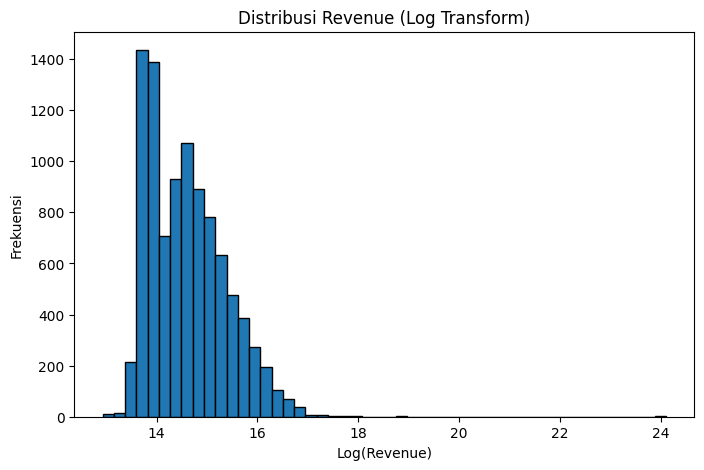

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(np.log1p(df_rev['Revenue']), bins=50, edgecolor='black')  # log1p = log(1+x)
plt.title("Distribusi Revenue (Log Transform)")
plt.xlabel("Log(Revenue)")
plt.ylabel("Frekuensi")
plt.show()

In [ ]:
## Total Revenue Per Channel

## Total Revenue Per Channel

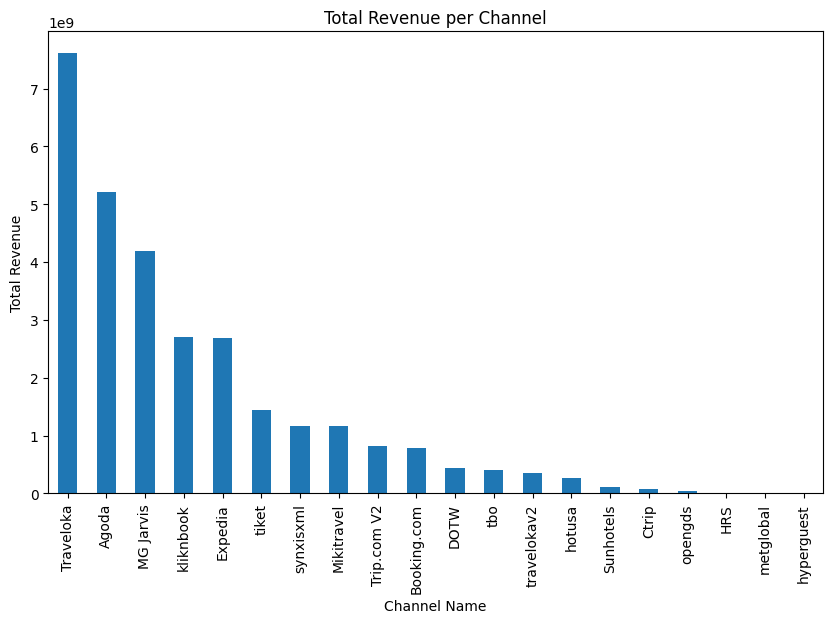

In [ ]:
plt.figure(figsize=(10,6))
df_rev.groupby('Channel Name')['Revenue'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Total Revenue per Channel")
plt.ylabel("Total Revenue")
plt.xlabel("Channel Name")
plt.show()


## Total Revenue Per Room Type

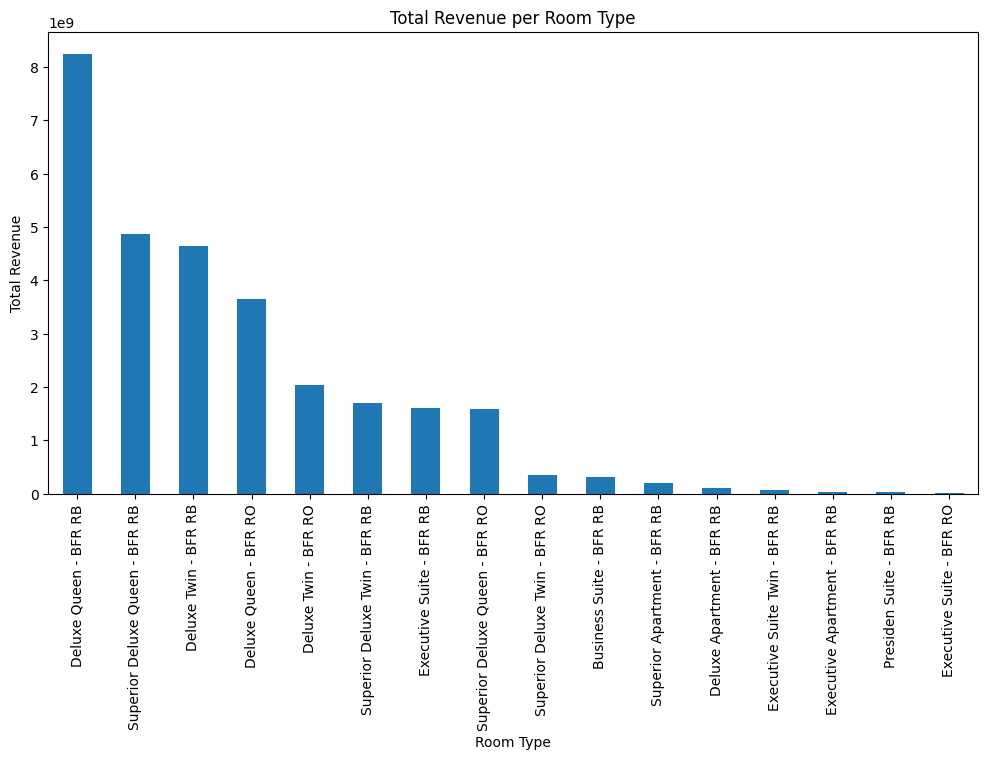

In [ ]:
plt.figure(figsize=(12,6))
df_rev.groupby('Room Type')['Revenue'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Total Revenue per Room Type")
plt.ylabel("Total Revenue")
plt.xlabel("Room Type")
plt.show()

## Revenue Trend by Date

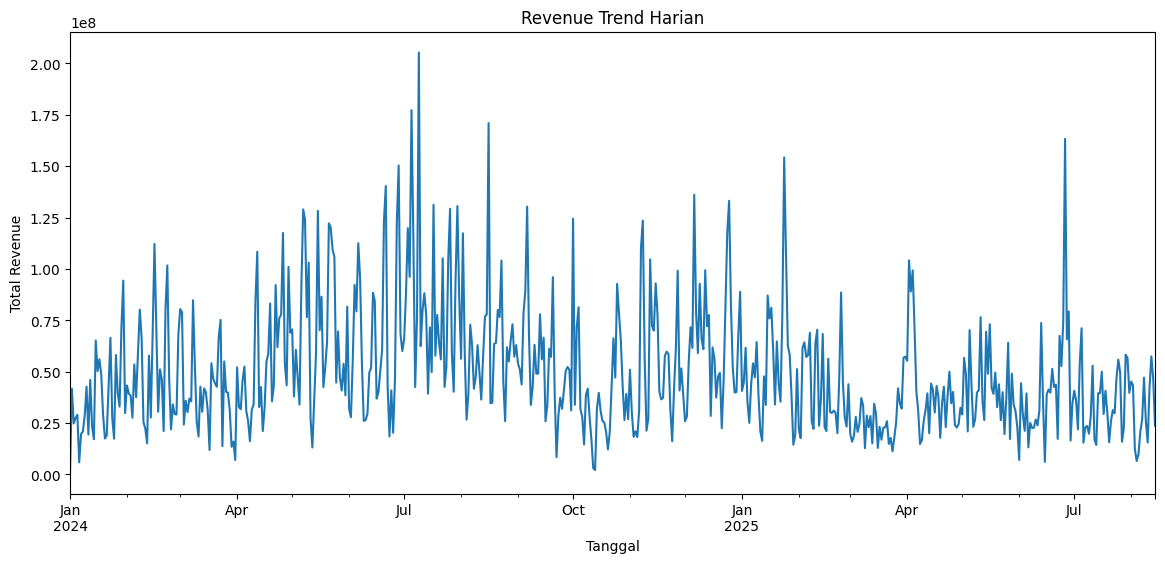

In [ ]:
# Buang baris yang berisi "Total" atau NaN pada kolom Date
df_rev = df_rev[~df_rev['Date'].str.contains("Total", na=False)]

# Konversi kolom Date jadi datetime
df_rev['Date'] = pd.to_datetime(df_rev['Date'], format='%d-%b-%y')

# Plot trend Revenue
plt.figure(figsize=(14,6))
df_rev.groupby('Date')['Revenue'].sum().plot()
plt.title("Revenue Trend Harian")
plt.xlabel("Tanggal")
plt.ylabel("Total Revenue")
plt.show()

# Feature Engineering Room Type

## Meal Plan

In [ ]:
# Meal Plan dari kode di Room Type
df_rev['Meal Plan'] = df_rev['Room Type'].apply(
    lambda x: "Room Only" if isinstance(x, str) and "RO" in x else ("Breakfast" if isinstance(x, str) and "RB" in x else "Unknown")
)

## Room Type

In [ ]:
# Room Category (hapus kode meal plan dari nama kamar)
df_rev['Room Category'] = df_rev['Room Type'].str.replace(r" - BFR.*", "", regex=True).str.strip()

## Seasonality

In [ ]:
# Buat kolom bulan
df_rev['Month'] = df_rev['Date'].dt.month

def seasonality(month):
    if month in [7, 8, 12]:
        return "High"
    elif month in [5, 6, 9]:
        return "Mid"
    else:
        return "Low"

df_rev['Seasonality'] = df_rev['Month'].apply(seasonality)

## Length of Stay

In [ ]:
# Asumsikan Room Nights = LOS
df_rev['Length of Stay'] = df_rev['Room Nights']

## Average Daily Rate (ADR)

In [ ]:
df_rev['ADR'] = df_rev['Revenue'] / df_rev['Room Nights']

## Day of Week (DoW)

In [ ]:
df_rev['Day of Week'] = df_rev['Date'].dt.day_name()
df_rev['Weekend Flag'] = df_rev['Day of Week'].apply(lambda x: 1 if x in ['Friday','Saturday'] else 0)

## Tampilkan Updated Data Frame

## Visualisasi

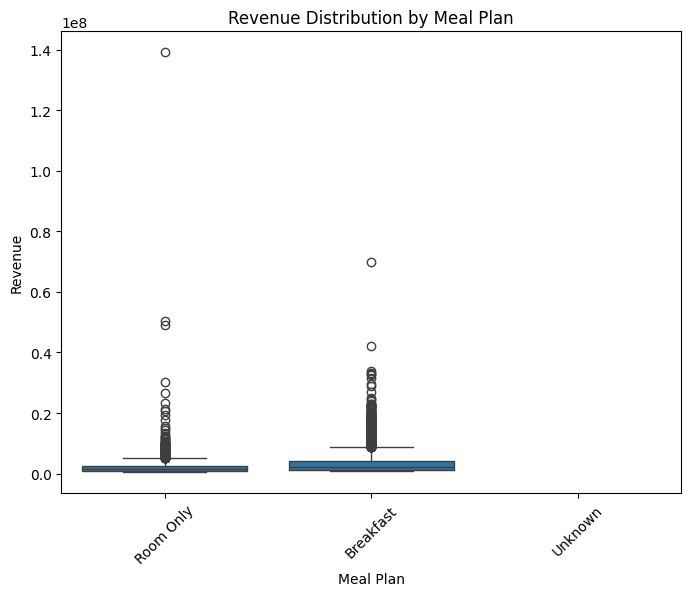

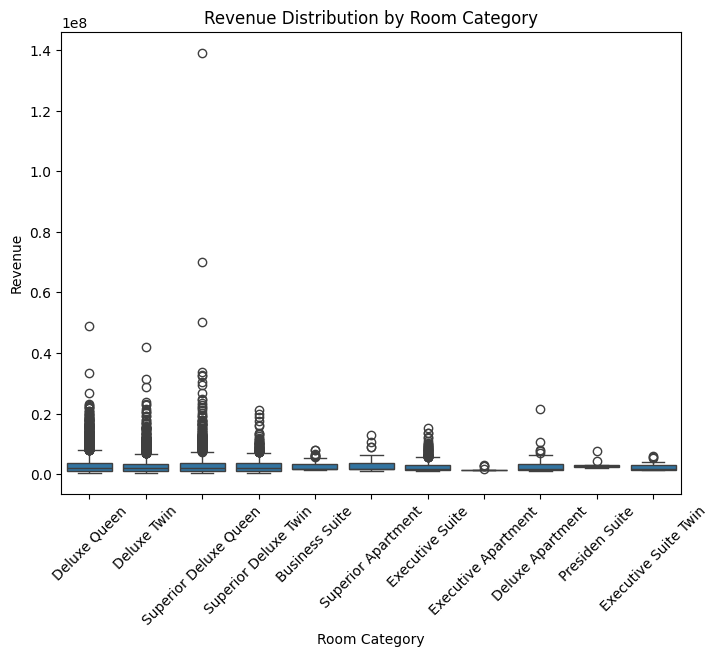

/tmp/ipython-input-4286239963.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="Month", y="Revenue", data=df_rev, estimator="sum", ci=None, marker="o")


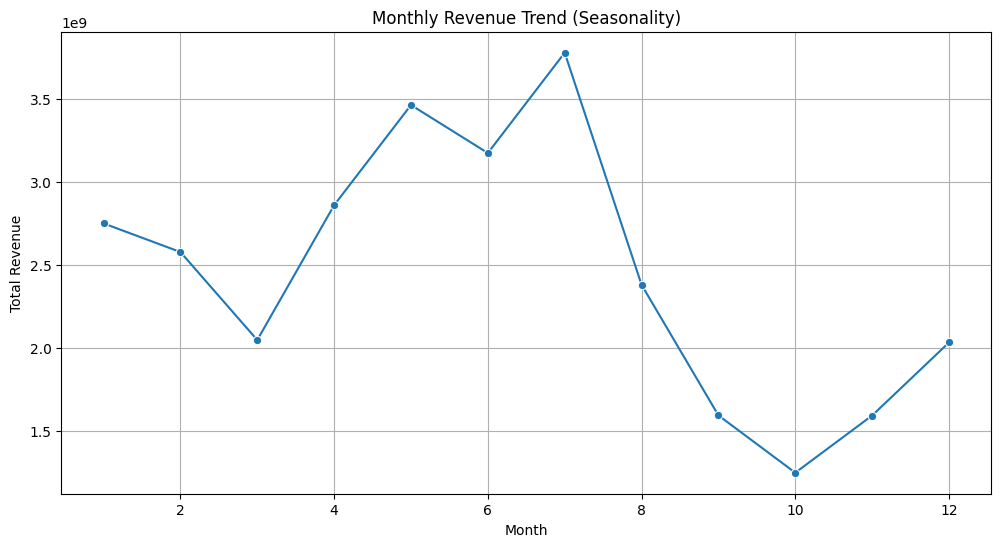

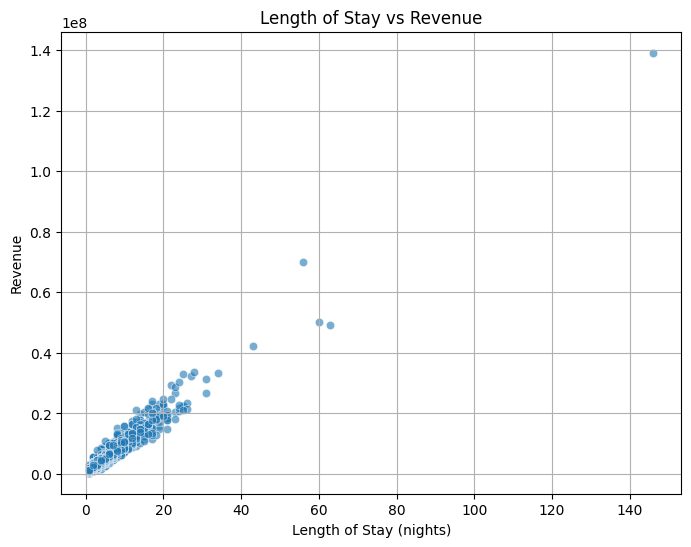

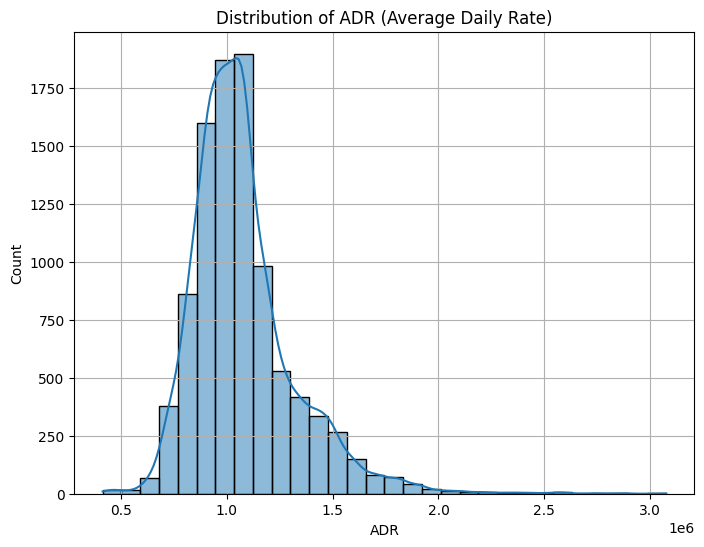

In [ ]:
# 1. Distribusi Meal Plan vs Revenue
plt.figure(figsize=(8,6))
sns.boxplot(x="Meal Plan", y="Revenue", data=df_rev)
plt.title("Revenue Distribution by Meal Plan")
plt.ylabel("Revenue")
plt.xlabel("Meal Plan")
plt.xticks(rotation=45)
plt.show()

# 2. Distribusi Room Category
plt.figure(figsize=(8,6))
sns.boxplot(x="Room Category", y="Revenue", data=df_rev)
plt.title("Revenue Distribution by Room Category")
plt.ylabel("Revenue")
plt.xlabel("Room Category")
plt.xticks(rotation=45)
plt.show()

# 3. Seasonality (Revenue per Month)
plt.figure(figsize=(12,6))
sns.lineplot(x="Month", y="Revenue", data=df_rev, estimator="sum", ci=None, marker="o")
plt.title("Monthly Revenue Trend (Seasonality)")
plt.ylabel("Total Revenue")
plt.xlabel("Month")
plt.grid(True)
plt.show()

# 4. Length of Stay vs Revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x="Length of Stay", y="Revenue", data=df_rev, alpha=0.6)
plt.title("Length of Stay vs Revenue")
plt.ylabel("Revenue")
plt.xlabel("Length of Stay (nights)")
plt.grid(True)
plt.show()

# 5. Tambahan: ADR (Average Daily Rate) distribusi
plt.figure(figsize=(8,6))
sns.histplot(df_rev['ADR'], bins=30, kde=True)
plt.title("Distribution of ADR (Average Daily Rate)")
plt.xlabel("ADR")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Data Preprocessing

## Checking Missing Values

In [ ]:
# --- Cek missing values ---
print("Missing Values:\n", df_rev.isnull().sum())

Missing Values:
 Date              6
Channel Name      6
Room Type         6
Room Nights       6
Revenue           6
Meal Plan         0
Room Category     6
Month             6
Seasonality       0
Length of Stay    6
ADR               6
Day of Week       6
Weekend Flag      0
dtype: int64


## Handling Missing Values

In [ ]:
# Revenue & Room Nights kosong
df_rev = df_rev.dropna(subset=['Revenue', 'Room Nights']).copy()

# Room Type kosong → isi dengan "Unknown"
df_rev.loc[:, 'Room Type'] = df_rev['Room Type'].fillna("Unknown")

# --- Cek lagi missing values ---
print("Missing Values:\n", df_rev.isnull().sum())

Missing Values:
 Date              0
Channel Name      0
Room Type         0
Room Nights       0
Revenue           0
Meal Plan         0
Room Category     0
Month             0
Seasonality       0
Length of Stay    0
ADR               0
Day of Week       0
Weekend Flag      0
dtype: int64


## Konversi Tipe Data

In [ ]:
df_rev['Date'] = pd.to_datetime(df_rev['Date'], errors='coerce')
df_rev['Revenue'] = df_rev['Revenue'].astype(float)
df_rev['Room Nights'] = df_rev['Room Nights'].astype(int)


## One Hot Encoding

In [ ]:
# One Hot Encoding for 'Channel Name'
df_encoded = pd.get_dummies(df_rev, columns=['Channel Name'], drop_first=True)
display(df_encoded.head())

,Date,Room Type,Room Nights,Revenue,Meal Plan,Room Category,Month,Seasonality,Length of Stay,ADR,...,Channel Name_Trip.com V2,Channel Name_hotusa,Channel Name_hyperguest,Channel Name_kliknbook,Channel Name_metglobal,Channel Name_opengds,Channel Name_synxisxml,Channel Name_tbo,Channel Name_tiket,Channel Name_travelokav2
0,2024-01-01,Deluxe Queen - BFR RO,1,850000.0,Room Only,Deluxe Queen,1.0,Low,1.0,850000.0,...,False,False,False,False,False,False,False,False,False,False
1,2024-01-02,Deluxe Twin - BFR RO,1,850000.0,Room Only,Deluxe Twin,1.0,Low,1.0,850000.0,...,False,False,False,False,False,False,False,False,False,False
2,2024-01-02,Deluxe Queen - BFR RO,1,850000.0,Room Only,Deluxe Queen,1.0,Low,1.0,850000.0,...,False,False,False,False,False,False,False,False,False,False
3,2024-01-02,Deluxe Queen - BFR RO,3,2550000.0,Room Only,Deluxe Queen,1.0,Low,3.0,850000.0,...,False,False,False,False,False,False,False,False,False,False
4,2024-01-02,Superior Deluxe Queen - BFR RO,1,950000.0,Room Only,Superior Deluxe Queen,1.0,Low,1.0,950000.0,...,False,False,False,False,False,False,False,False,False,False


## Label Encoder

In [ ]:
# Encode semua kolom kategori
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

## Stasionarity Data

In [ ]:
result = adfuller(df_rev['Revenue'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -21.781129
p-value: 0.000000


## Drop unused feature

In [ ]:
df_encoded = df_encoded.drop(columns=['Room Type'])

In [ ]:
df_encoded.head()

,Date,Room Nights,Revenue,Meal Plan,Room Category,Month,Seasonality,Length of Stay,ADR,Day of Week,...,Channel Name_Trip.com V2,Channel Name_hotusa,Channel Name_hyperguest,Channel Name_kliknbook,Channel Name_metglobal,Channel Name_opengds,Channel Name_synxisxml,Channel Name_tbo,Channel Name_tiket,Channel Name_travelokav2
0,2024-01-01,1,850000.0,1,2,1.0,1,1.0,850000.0,1,...,False,False,False,False,False,False,False,False,False,False
1,2024-01-02,1,850000.0,1,3,1.0,1,1.0,850000.0,5,...,False,False,False,False,False,False,False,False,False,False
2,2024-01-02,1,850000.0,1,2,1.0,1,1.0,850000.0,5,...,False,False,False,False,False,False,False,False,False,False
3,2024-01-02,3,2550000.0,1,2,1.0,1,3.0,850000.0,5,...,False,False,False,False,False,False,False,False,False,False
4,2024-01-02,1,950000.0,1,9,1.0,1,1.0,950000.0,5,...,False,False,False,False,False,False,False,False,False,False


#Membuat heatmap dari correlation

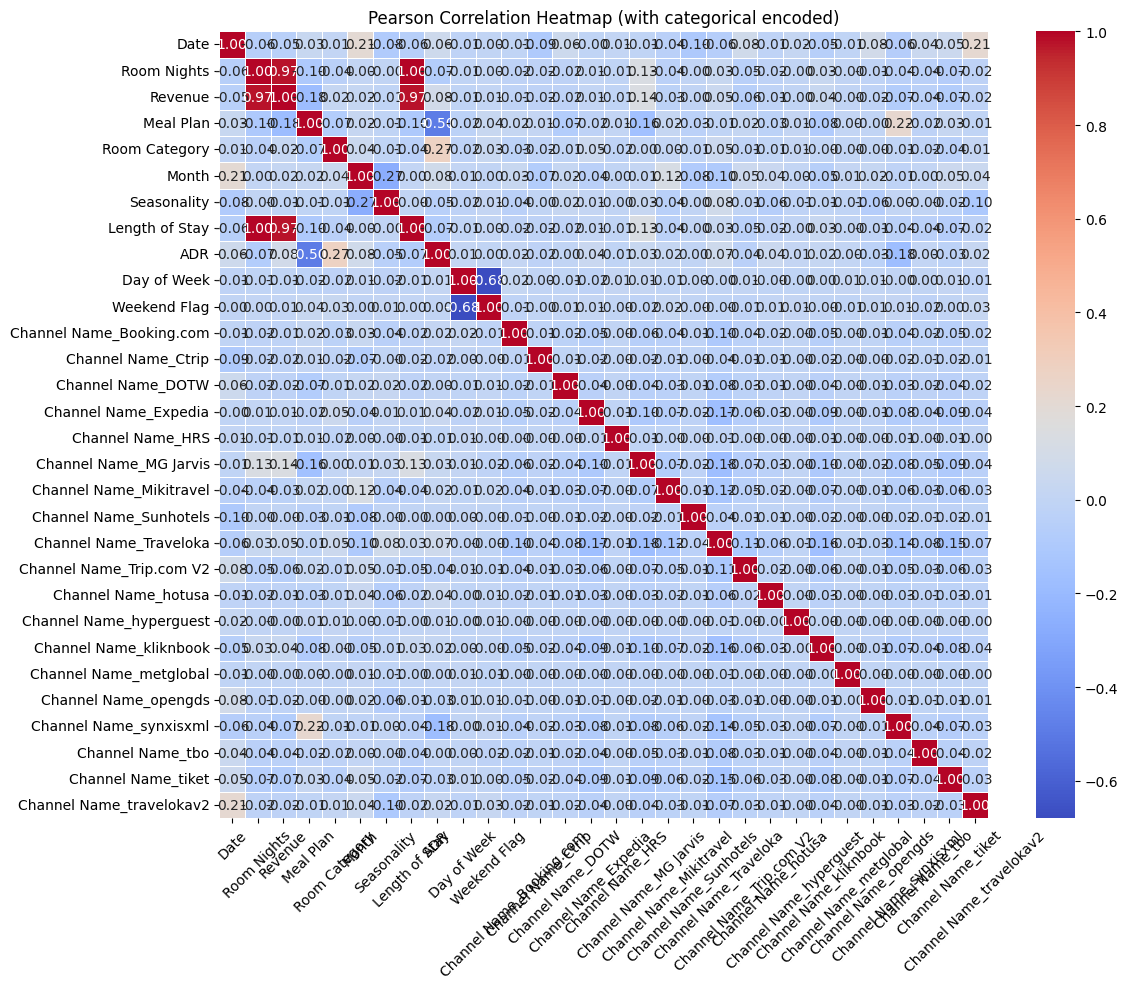

In [ ]:
# Hitung korelasi Pearson
correlation_matrix = df_encoded.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Heatmap (with categorical encoded)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Feature Selection

Top Features correlated with Revenue:
Revenue           1.000000
Room Nights       0.973878
Length of Stay    0.973878
ADR               0.082405
Month             0.020213
Weekend Flag      0.005113
Name: Revenue, dtype: float64


/tmp/ipython-input-1087902984.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation.index, y=correlation.values, palette="viridis")


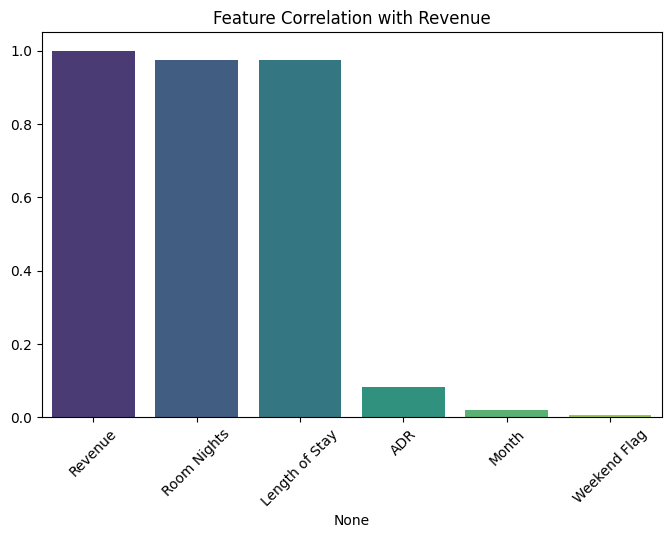

In [ ]:
# Ambil hanya kolom numerik
numeric_df = df_rev.select_dtypes(include=['float64', 'int64'])

# Hitung korelasi dengan Revenue
correlation = numeric_df.corr()['Revenue'].sort_values(ascending=False)

print("Top Features correlated with Revenue:")
print(correlation)

# Visualisasi
plt.figure(figsize=(8,5))
sns.barplot(x=correlation.index, y=correlation.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Feature Correlation with Revenue")
plt.show()

In [ ]:
# Reorder columns to put 'Revenue' at the end
cols = list(df_encoded.columns)
cols.remove('Revenue')
cols.append('Revenue')
df_encoded = df_encoded[cols]

display(df_encoded.head())

,Date,Room Nights,Meal Plan,Room Category,Month,Seasonality,Length of Stay,ADR,Day of Week,Weekend Flag,...,Channel Name_hotusa,Channel Name_hyperguest,Channel Name_kliknbook,Channel Name_metglobal,Channel Name_opengds,Channel Name_synxisxml,Channel Name_tbo,Channel Name_tiket,Channel Name_travelokav2,Revenue
0,2024-01-01,1,1,2,1.0,1,1.0,850000.0,1,0,...,False,False,False,False,False,False,False,False,False,850000.0
1,2024-01-02,1,1,3,1.0,1,1.0,850000.0,5,0,...,False,False,False,False,False,False,False,False,False,850000.0
2,2024-01-02,1,1,2,1.0,1,1.0,850000.0,5,0,...,False,False,False,False,False,False,False,False,False,850000.0
3,2024-01-02,3,1,2,1.0,1,3.0,850000.0,5,0,...,False,False,False,False,False,False,False,False,False,2550000.0
4,2024-01-02,1,1,9,1.0,1,1.0,950000.0,5,0,...,False,False,False,False,False,False,False,False,False,950000.0


# Aggregate Data to daily


In [ ]:
df_encoded.head()

,Date,Room Nights,Meal Plan,Room Category,Month,Seasonality,Length of Stay,ADR,Day of Week,Weekend Flag,...,Channel Name_hotusa,Channel Name_hyperguest,Channel Name_kliknbook,Channel Name_metglobal,Channel Name_opengds,Channel Name_synxisxml,Channel Name_tbo,Channel Name_tiket,Channel Name_travelokav2,Revenue
0,2024-01-01,1,1,2,1.0,1,1.0,850000.0,1,0,...,False,False,False,False,False,False,False,False,False,850000.0
1,2024-01-02,1,1,3,1.0,1,1.0,850000.0,5,0,...,False,False,False,False,False,False,False,False,False,850000.0
2,2024-01-02,1,1,2,1.0,1,1.0,850000.0,5,0,...,False,False,False,False,False,False,False,False,False,850000.0
3,2024-01-02,3,1,2,1.0,1,3.0,850000.0,5,0,...,False,False,False,False,False,False,False,False,False,2550000.0
4,2024-01-02,1,1,9,1.0,1,1.0,950000.0,5,0,...,False,False,False,False,False,False,False,False,False,950000.0


In [ ]:
# Define aggregation functions for each column
aggregation_functions = {
    'Room Nights': 'sum',
    'Meal Plan': 'sum',
    'Room Category': 'sum',
    'Length of Stay': 'sum',
    'ADR': 'sum',
    'Month': 'mean',
    'Seasonality': 'mean',
    'Day of Week': 'mean',
    'Weekend Flag': 'mean',
    'Channel Name_Booking.com': 'sum',
    'Channel Name_Ctrip': 'sum',
    'Channel Name_DOTW': 'sum',
    'Channel Name_Expedia': 'sum',
    'Channel Name_HRS': 'sum',
    'Channel Name_MG Jarvis': 'sum',
    'Channel Name_Mikitravel': 'sum',
    'Channel Name_Sunhotels': 'sum',
    'Channel Name_Traveloka': 'sum',
    'Channel Name_Trip.com V2': 'sum',
    'Channel Name_hotusa': 'sum',
    'Channel Name_hyperguest': 'sum',
    'Channel Name_kliknbook': 'sum',
    'Channel Name_metglobal': 'sum',
    'Channel Name_opengds': 'sum',
    'Channel Name_synxisxml': 'sum',
    'Channel Name_tbo': 'sum',
    'Channel Name_tiket': 'sum',
    'Channel Name_travelokav2': 'sum',
    'Revenue': 'sum'
}

# Aggregate data to daily
df_daily = df_encoded.groupby('Date').agg(aggregation_functions).reset_index()

# Display the aggregated data
display(df_daily.head())

,Date,Room Nights,Meal Plan,Room Category,Length of Stay,ADR,Month,Seasonality,Day of Week,Weekend Flag,...,Channel Name_hotusa,Channel Name_hyperguest,Channel Name_kliknbook,Channel Name_metglobal,Channel Name_opengds,Channel Name_synxisxml,Channel Name_tbo,Channel Name_tiket,Channel Name_travelokav2,Revenue
0,2024-01-01,1,1,2,1.0,8.500000e+05,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,850000.0
1,2024-01-02,45,5,63,45.0,1.392152e+07,1.0,1.0,5.0,0.0,...,0,0,2,0,0,0,0,0,0,41640000.0
2,2024-01-03,26,6,81,26.0,1.590167e+07,1.0,1.0,6.0,0.0,...,0,0,2,0,0,1,0,1,0,24745000.0
3,2024-01-04,22,1,54,22.0,1.452834e+07,1.0,1.0,4.0,0.0,...,1,0,2,0,0,1,0,0,0,27391199.0
4,2024-01-05,28,1,33,28.0,8.049227e+06,1.0,1.0,0.0,1.0,...,1,0,3,0,0,1,0,0,0,28946500.0


# Train Test Split

In [ ]:
# Pastikan data diurutkan berdasarkan kolom date
daily_revenue = df_daily.sort_values(by='Date')

# Hitung indeks 80% untuk pembagian data
split_index = int(len(daily_revenue) * 0.8)

# Split data menjadi train dan test
train_df = daily_revenue.iloc[:split_index]
test_df = daily_revenue.iloc[split_index:]

# Cek ukuran hasil split
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (473, 30)
Test shape: (119, 30)


# Modelling

## ARIMA

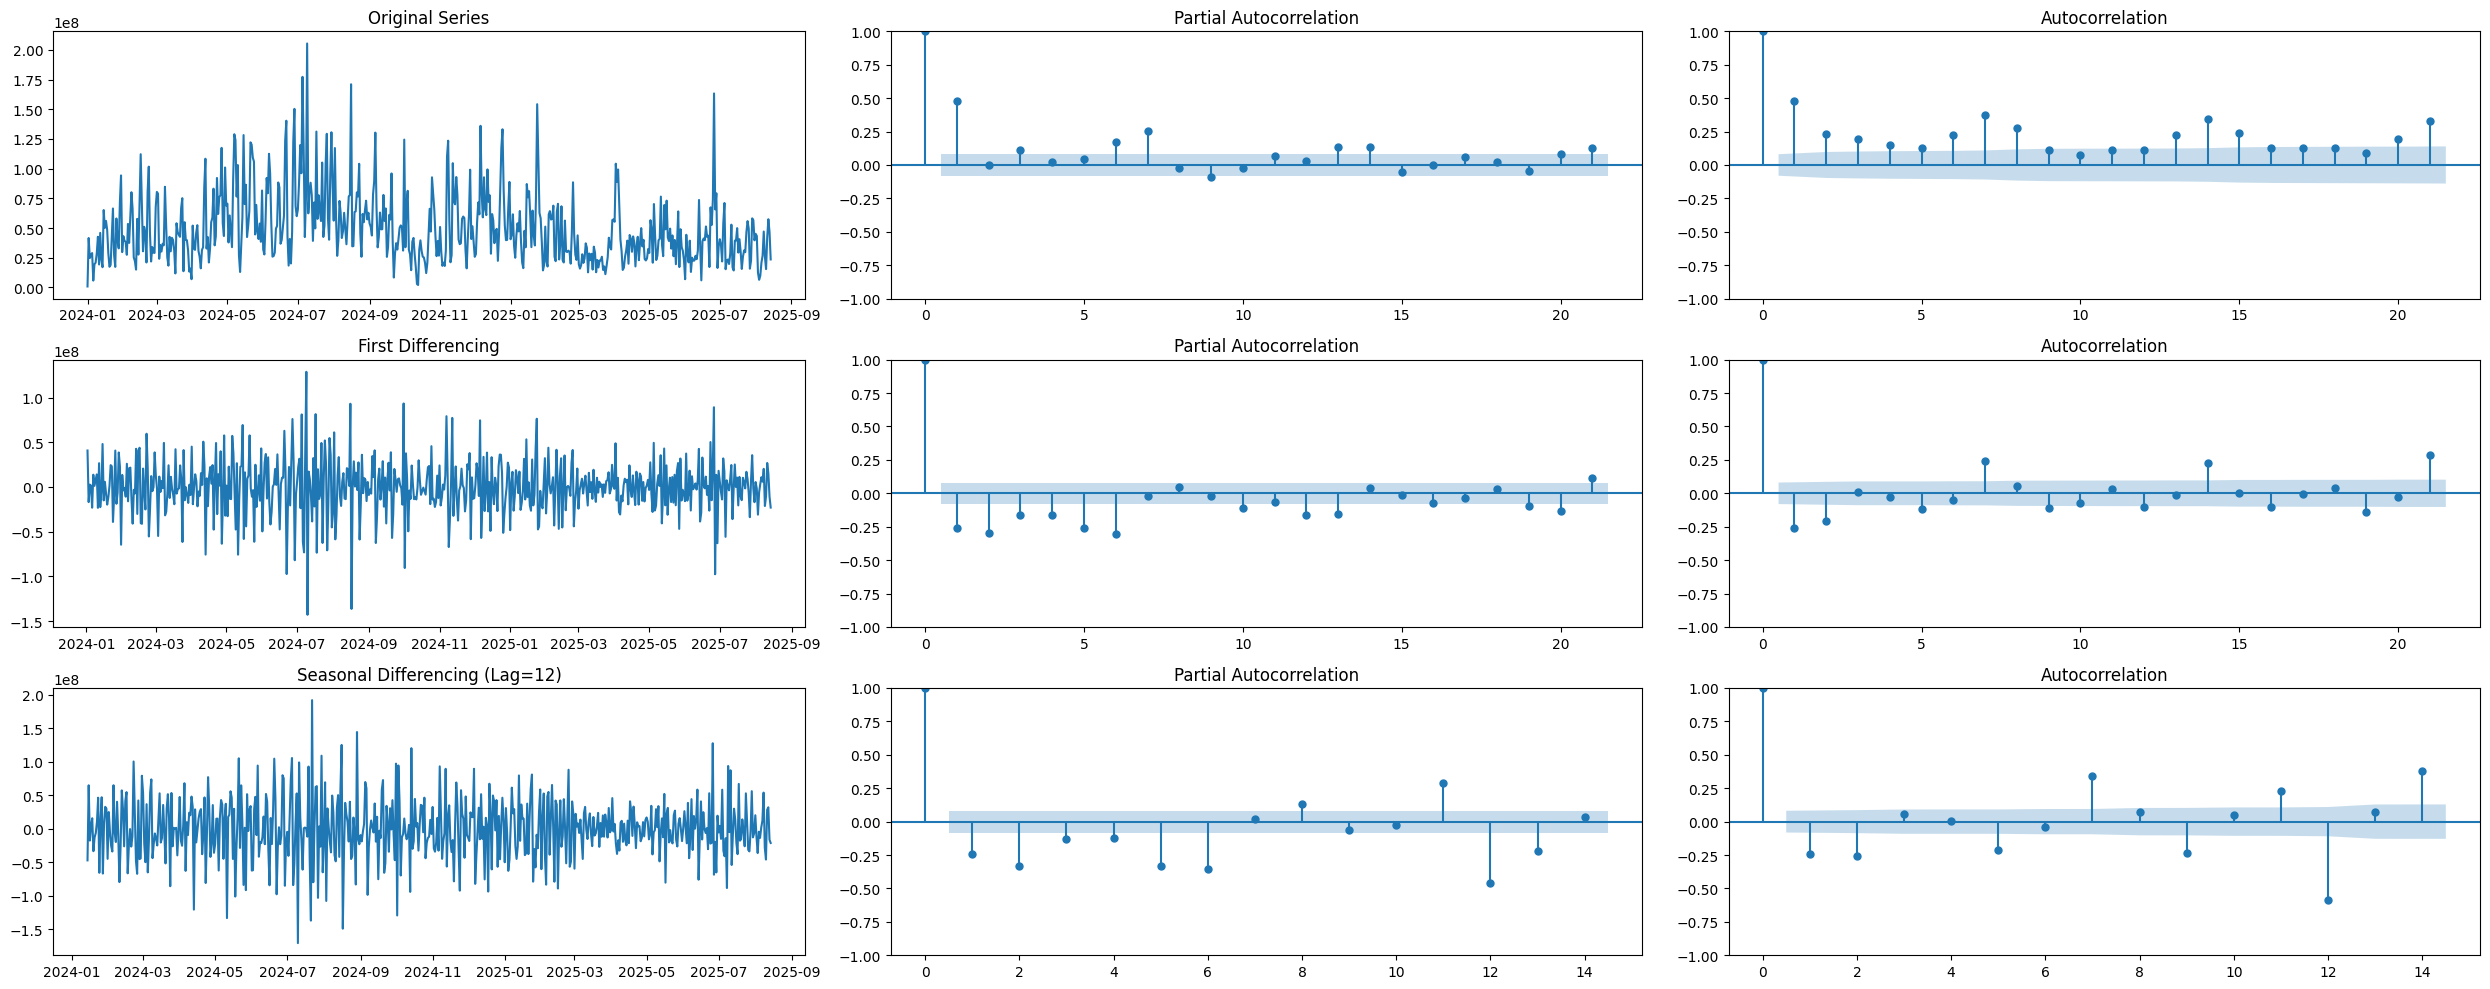

In [ ]:
# Siapkan plot
fig, ax = plt.subplots(3, 3, figsize=(25, 10))

# Plot Original Series
ax[0, 0].set_title('Original Series')
ax[0, 0].plot(daily_revenue['Date'], daily_revenue['Revenue'])
plot_pacf(daily_revenue['Revenue'], ax=ax[0, 1], lags=21)
plot_acf(daily_revenue['Revenue'], ax=ax[0, 2], lags=21)

# First Differencing
diff1 = daily_revenue['Revenue'].diff().dropna()
ax[1, 0].set_title('First Differencing')
ax[1, 0].plot(daily_revenue['Date'][1:], diff1)
plot_pacf(diff1, ax=ax[1, 1], lags=21)
plot_acf(diff1, ax=ax[1, 2], lags=21)

# Seasonal Differencing (lag 12)
diff2 = daily_revenue['Revenue'].diff().diff(12).dropna()
ax[2, 0].set_title('Seasonal Differencing (Lag=12)')
ax[2, 0].plot(daily_revenue['Date'][13:], diff2)
plot_pacf(diff2, ax=ax[2, 1], lags=14)
plot_acf(diff2, ax=ax[2, 2], lags=14)

plt.tight_layout()
plt.show()

In [ ]:
ori_orders = {
    (1, 0, 1), (1, 0, 2),

    (2, 0, 1), (2, 0, 2)
}

diff_orders1 = {
    (1, 1, 1), (1, 1, 2), (1, 1, 3),

    (1, 1, 4), (1, 1, 5), (1, 1, 6),
    }

diff_orders2 = {
    (1, 2, 1), (1, 2, 2), (1, 2, 3),

    (11, 2, 1), (11, 2, 2), (11, 2, 3),

    (12, 2, 1), (12, 2, 2), (12, 2, 3),
    }

In [ ]:
import itertools

best_aic = float('inf')
best_order = None
best_model_fit = None

# Iterasi melalui setiap kombinasi (p, d, q) dalam diff_orders
for order in ori_orders:
    p, d, q = order
    try:
        # Buat model ARIMA dengan order saat ini
        model = ARIMA(train_df['Revenue'], order=(p, d, q))

        # Fit model
        model_fit = model.fit()

        # Ambil nilai AIC
        aic = model_fit.aic

        print(f'ARIMA{order} AIC: {aic:.3f}')

        # Periksa apakah AIC saat ini lebih kecil dari best_aic yang sudah ditemukan
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model_fit = model_fit

    except Exception as e:
        print(f'Could not fit ARIMA{order}: {e}')
        continue

print(f'\nBest ARIMA model is ARIMA{best_order} with AIC: {best_aic:.3f}')

# Tampilkan summary dari model terbaik
if best_model_fit:
    print("\nSummary of the Best ARIMA Model:")
    print(best_model_fit.summary())

    # Anda juga bisa menyimpan atau menggunakan best_model_fit untuk prediksi
    # Misalnya: predictions = best_model_fit.predict(start=len(train_df), end=len(monthly_groceries)-1)
else:
    print("No suitable ARIMA model found from the specified orders.")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 1) AIC: 17544.443
ARIMA(1, 0, 1) AIC: 17543.844
ARIMA(1, 0, 2) AIC: 17522.041
ARIMA(2, 0, 2) AIC: 17523.812

Best ARIMA model is ARIMA(1, 0, 2) with AIC: 17522.041

Summary of the Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  473
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -8756.020
Date:                Tue, 09 Sep 2025   AIC                          17522.041
Time:                        09:38:24   BIC                          17542.836
Sample:                             0   HQIC                         17530.220
                                - 473                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


In [ ]:
import itertools

best_aic = float('inf')
best_order = None
best_model_fit = None

# Iterasi melalui setiap kombinasi (p, d, q) dalam diff_orders
for order in diff_orders1:
    p, d, q = order
    try:
        # Buat model ARIMA dengan order saat ini
        model = ARIMA(train_df['Revenue'], order=(p, d, q))

        # Fit model
        model_fit = model.fit()

        # Ambil nilai AIC
        aic = model_fit.aic

        print(f'ARIMA{order} AIC: {aic:.3f}')

        # Periksa apakah AIC saat ini lebih kecil dari best_aic yang sudah ditemukan
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model_fit = model_fit

    except Exception as e:
        print(f'Could not fit ARIMA{order}: {e}')
        continue

print(f'\nBest ARIMA model is ARIMA{best_order} with AIC: {best_aic:.3f}')

# Tampilkan summary dari model terbaik
if best_model_fit:
    print("\nSummary of the Best ARIMA Model:")
    print(best_model_fit.summary())

    # Anda juga bisa menyimpan atau menggunakan best_model_fit untuk prediksi
    # Misalnya: predictions = best_model_fit.predict(start=len(train_df), end=len(monthly_groceries)-1)
else:
    print("No suitable ARIMA model found from the specified orders.")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 5) AIC: 17494.535
ARIMA(1, 1, 3) AIC: 17490.928
ARIMA(1, 1, 4) AIC: 17493.353


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 6) AIC: 17487.456
ARIMA(1, 1, 1) AIC: 17499.358
ARIMA(1, 1, 2) AIC: 17488.161

Best ARIMA model is ARIMA(1, 1, 6) with AIC: 17487.456

Summary of the Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  473
Model:                 ARIMA(1, 1, 6)   Log Likelihood               -8735.728
Date:                Tue, 09 Sep 2025   AIC                          17487.456
Time:                        09:38:27   BIC                          17520.712
Sample:                             0   HQIC                         17500.537
                                - 473                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3190      0.2

In [ ]:
best_aic = float('inf')
best_order = None
best_model_fit = None

# Iterasi melalui setiap kombinasi (p, d, q) dalam diff_orders
for order in diff_orders2:
    p, d, q = order
    try:
        # Buat model ARIMA dengan order saat ini
        model = ARIMA(train_df['Revenue'], order=(p, d, q))

        # Fit model
        model_fit = model.fit()

        # Ambil nilai AIC
        aic = model_fit.aic

        print(f'ARIMA{order} AIC: {aic:.3f}')

        # Periksa apakah AIC saat ini lebih kecil dari best_aic yang sudah ditemukan
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model_fit = model_fit

    except Exception as e:
        print(f'Could not fit ARIMA{order}: {e}')
        continue

print(f'\nBest ARIMA model is ARIMA{best_order} with AIC: {best_aic:.3f}')

# Tampilkan summary dari model terbaik
if best_model_fit:
    print("\nSummary of the Best ARIMA Model:")
    print(best_model_fit.summary())

    # Anda juga bisa menyimpan atau menggunakan best_model_fit untuk prediksi
    # Misalnya: predictions = best_model_fit.predict(start=len(train_df), end=len(monthly_groceries)-1)
else:
    print("No suitable ARIMA model found from the specified orders.")

ARIMA(1, 2, 1) AIC: 17612.148


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(11, 2, 2) AIC: 17458.192


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 3) AIC: 17481.069


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels

ARIMA(12, 2, 2) AIC: 17458.384
ARIMA(11, 2, 1) AIC: 17454.996


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 2) AIC: 17622.403


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(12, 2, 1) AIC: 17444.081


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(11, 2, 3) AIC: 17451.867
ARIMA(12, 2, 3) AIC: 17460.250

Best ARIMA model is ARIMA(12, 2, 1) with AIC: 17444.081

Summary of the Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  473
Model:                ARIMA(12, 2, 1)   Log Likelihood               -8708.040
Date:                Tue, 09 Sep 2025   AIC                          17444.081
Time:                        09:38:59   BIC                          17502.249
Sample:                             0   HQIC                         17466.964
                                - 473                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5351      0.044    -12.039      0.000   

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## SARIMA

In [ ]:
model = ARIMA(train_df['Revenue'], order=(1,0,1), seasonal_order=(1,0,1,7))

model_fit_cross = model.fit()

print(model_fit_cross.summary())

                                    SARIMAX Results                                    
Dep. Variable:                         Revenue   No. Observations:                  473
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -8720.305
Date:                         Tue, 09 Sep 2025   AIC                          17452.610
Time:                                 09:38:59   BIC                          17477.564
Sample:                                      0   HQIC                         17462.425
                                         - 473                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.296e+07   1.05e-10   5.02e+17      0.000     5.3e+07     5.3e+07
ar.L1          0.5502      0.115      4.805      0.000     

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


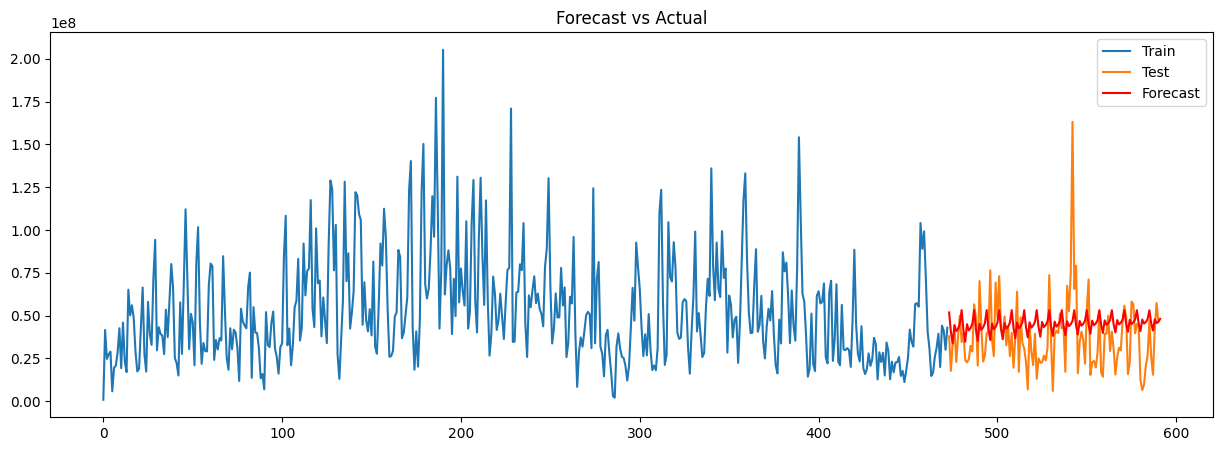

In [ ]:
# Prediction

forecast = model_fit_cross.predict(start=len(train_df), end=len(train_df)+len(test_df)-1, typ='levels')

forecast.index = test_df.index
plt.figure(figsize=(15,5))

plt.title('Forecast vs Actual')

plt.plot(train_df['Revenue'], label='Train')

plt.plot(test_df['Revenue'].iloc[:-1], label='Test')

plt.plot(forecast, label='Forecast', color='r')

plt.legend()

In [ ]:
#Tambah evaluation error di MAE, MAP, MASE

import numpy as np
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_scaled_error(y_true, y_pred):
    # Calculate absolute errors of the naive forecast
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    mae_forecast = np.mean(np.abs(y_true - y_pred))

    # Handle cases where mae_naive is zero (constant actuals)
    if mae_naive == 0:
        return np.inf if mae_forecast > 0 else 0
    return mae_forecast / mae_naive

# Calculate evaluation metrics
mae = mean_absolute_error(test_df['Revenue'].iloc[:-1], forecast.iloc[:-1])
mape = mean_absolute_percentage_error(test_df['Revenue'].iloc[:-1], forecast.iloc[:-1])
mase = mean_absolute_scaled_error(test_df['Revenue'].iloc[:-1], forecast.iloc[:-1])
rmse = np.sqrt(mean_squared_error(test_df['Revenue'].iloc[:-1], forecast.iloc[:-1]))


print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.3f}%")
print(f"MASE: {mase:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE: 15684697.379
MAPE: 68.349%
MASE: 0.874
RMSE: 20805637.357


## SARIMAX

In [ ]:
model = ARIMA(train_df['Revenue'], order=(1,0,1), seasonal_order=(1,0,1,7), exog=train_df[['Room Nights', 'Meal Plan', 'Room Category', 'Length of Stay', 'ADR',
                                                                                           'Month', 'Seasonality', 'Day of Week','Weekend Flag','Channel Name_Booking.com',
                                                                                           'Channel Name_Ctrip', 'Channel Name_DOTW',
                                                                                           'Channel Name_Expedia', 'Channel Name_HRS', 'Channel Name_MG Jarvis',
                                                                                           'Channel Name_Mikitravel', 'Channel Name_Sunhotels', 'Channel Name_Traveloka',
                                                                                           'Channel Name_Trip.com V2', 'Channel Name_hotusa', 'Channel Name_hyperguest',
                                                                                           'Channel Name_kliknbook', 'Channel Name_metglobal', 'Channel Name_opengds',
                                                                                           'Channel Name_synxisxml', 'Channel Name_tbo', 'Channel Name_tiket',
                                                                                           'Channel Name_travelokav2']])

model_fit_cross = model.fit()

print(model_fit_cross.summary())

                                    SARIMAX Results                                    
Dep. Variable:                         Revenue   No. Observations:                  473
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -7788.529
Date:                         Tue, 09 Sep 2025   AIC                          15645.058
Time:                                 09:39:23   BIC                          15786.467
Sample:                                      0   HQIC                         15700.677
                                         - 473                                         
Covariance Type:                           opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -2.195e+06   2.86e+04    -76.816      0.000   -2.25e+06   -2.14e+06
Room Nights      

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


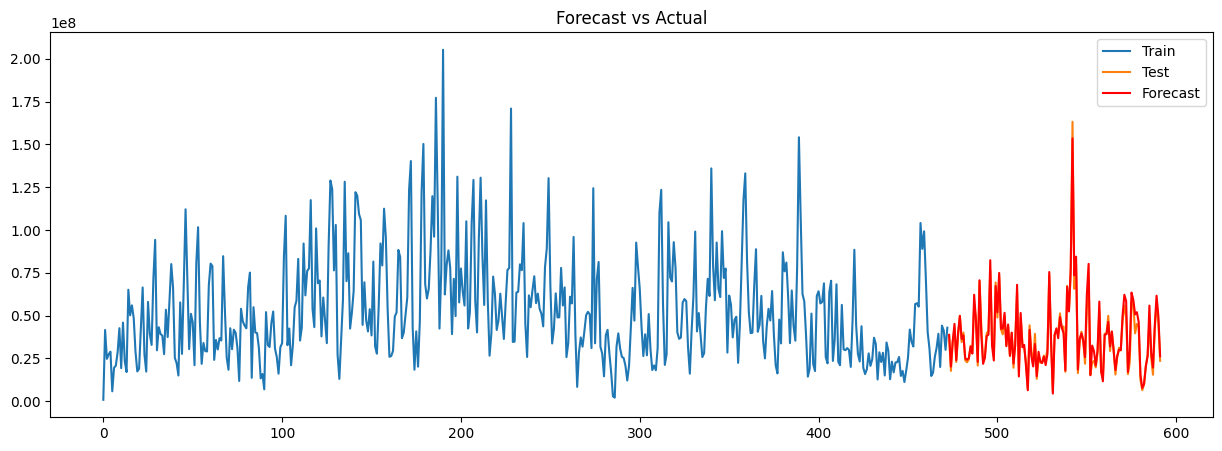

In [ ]:
# Forecast
forecast = model_fit_cross.predict(
    start=len(train_df),
    end=len(train_df)+len(test_df)-1,
    typ='levels',
    exog=test_df[['Room Nights', 'Meal Plan', 'Room Category', 'Length of Stay', 'ADR',
                  'Month', 'Seasonality', 'Day of Week','Weekend Flag','Channel Name_Booking.com',
                  'Channel Name_Ctrip', 'Channel Name_DOTW', 'Channel Name_Expedia',
                  'Channel Name_HRS', 'Channel Name_MG Jarvis', 'Channel Name_Mikitravel',
                  'Channel Name_Sunhotels', 'Channel Name_Traveloka','Channel Name_Trip.com V2',
                  'Channel Name_hotusa', 'Channel Name_hyperguest', 'Channel Name_kliknbook',
                  'Channel Name_metglobal', 'Channel Name_opengds','Channel Name_synxisxml',
                  'Channel Name_tbo', 'Channel Name_tiket','Channel Name_travelokav2']]
)

# Pastikan forecast pakai index tanggal test_df
forecast.index = test_df.index

# Plot
plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')

plt.plot(train_df['Revenue'], label='Train')
plt.plot(test_df['Revenue'], label='Test')
plt.plot(forecast, label='Forecast', color='r')

plt.legend()
plt.show()

In [ ]:
#Tambah evaluation error di MAE, MAP, MASE

import numpy as np
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_scaled_error(y_true, y_pred):
    # Calculate absolute errors of the naive forecast
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    mae_forecast = np.mean(np.abs(y_true - y_pred))

    # Handle cases where mae_naive is zero (constant actuals)
    if mae_naive == 0:
        return np.inf if mae_forecast > 0 else 0
    return mae_forecast / mae_naive

# Calculate evaluation metrics
mae = mean_absolute_error(test_df['Revenue'].iloc[:-1], forecast.iloc[:-1])
mape = mean_absolute_percentage_error(test_df['Revenue'].iloc[:-1], forecast.iloc[:-1])
mase = mean_absolute_scaled_error(test_df['Revenue'].iloc[:-1], forecast.iloc[:-1])
rmse = np.sqrt(mean_squared_error(test_df['Revenue'].iloc[:-1], forecast.iloc[:-1]))


print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.3f}%")
print(f"MASE: {mase:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE: 2626886.521
MAPE: 7.897%
MASE: 0.146
RMSE: 3560825.114


## Auto Arima

In [ ]:
!pip uninstall -y numpy scipy scikit-learn pmdarima
!pip install numpy==1.26.4 scipy==1.13.1 scikit-learn==1.4.2 pmdarima==2.0.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.16.1
Uninstalling scipy-1.16.1:
  Successfully uninstalled scipy-1.16.1
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0

In [ ]:
import pmdarima as pm

model = pm.auto_arima(train_df['Revenue'],
                      start_p=1,        # nilai p pertama
                      start_q=1,        # nilai q pertama
                      test='adf',       # gunakan adftest untuk mencari optimal 'd'
                      max_p=5,          # maksimal p
                      max_q=5,          # maksimal q
                      d=0,           # let model determine 'd'
                      m=7,             # frequency of series
                      seasonal=True,    # Seasonality
                      start_P=1,        # nilai P pertama
                      D=1,           # let model determine 'D'
                      start_Q=1,        # nilai Q pertama
                      max_P=1,          # maksimal P
                      max_D=0,          # maksimal D
                      max_Q=1,         # maksimal Q
                      exog=train_df[['Room Nights', 'Meal Plan', 'Room Category', 'Length of Stay', 'ADR',
                                     'Month', 'Seasonality', 'Day of Week','Weekend Flag','Channel Name_Booking.com',
                                     'Channel Name_Ctrip', 'Channel Name_DOTW', 'Channel Name_Expedia',
                                     'Channel Name_HRS', 'Channel Name_MG Jarvis', 'Channel Name_Mikitravel',
                                     'Channel Name_Sunhotels', 'Channel Name_Traveloka','Channel Name_Trip.com V2',
                                     'Channel Name_hotusa', 'Channel Name_hyperguest', 'Channel Name_kliknbook',
                                     'Channel Name_metglobal', 'Channel Name_opengds','Channel Name_synxisxml',
                                     'Channel Name_tbo', 'Channel Name_tiket','Channel Name_travelokav2']],
                      trace=True,       # print result
                      error_action='ignore',    # we don't want to know if an order does not work
                      suppress_warnings=True,   # we don't want convergence warnings
                      stepwise=True)        # set to stepwise

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=17252.873, Time=1.25 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=17504.213, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=17327.944, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=17273.067, Time=0.87 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=17502.283, Time=0.03 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=17251.027, Time=0.72 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=17434.820, Time=0.31 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=17330.076, Time=1.07 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=17249.623, Time=0.62 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=17434.018, Time=0.15 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=17251.550, Time=0.90 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=17347.280, Time=0.21 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=17250.871, Time=0.40 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=17251.928, Time=1.88 sec
 ARIMA(1,0,0)(0,1,1

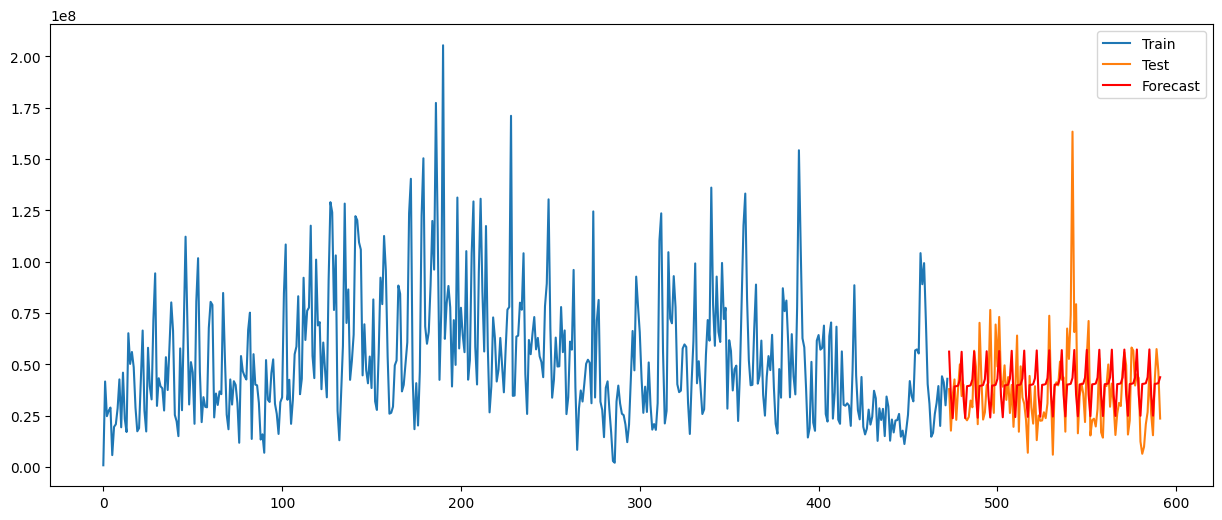

In [ ]:
# prediksi in-sample
fitted_values = model.predict_in_sample(exogenous=train_df[['Room Nights', 'Meal Plan', 'Room Category',
                                                           'Length of Stay', 'ADR','Month', 'Seasonality',
                                                           'Day of Week','Weekend Flag','Channel Name_Booking.com',
                                                           'Channel Name_Ctrip', 'Channel Name_DOTW',
                                                           'Channel Name_Expedia','Channel Name_HRS',
                                                           'Channel Name_MG Jarvis', 'Channel Name_Mikitravel',
                                                           'Channel Name_Sunhotels', 'Channel Name_Traveloka',
                                                           'Channel Name_Trip.com V2','Channel Name_hotusa',
                                                           'Channel Name_hyperguest', 'Channel Name_kliknbook',
                                                           'Channel Name_metglobal', 'Channel Name_opengds',
                                                           'Channel Name_synxisxml','Channel Name_tbo',
                                                           'Channel Name_tiket','Channel Name_travelokav2']])

# prediksi out-sample (misalnya 30 langkah ke depan dengan test set)
forecast = model.predict(n_periods=len(test_df),
                         exogenous=test_df[['Room Nights', 'Meal Plan', 'Room Category',
                                            'Length of Stay', 'ADR','Month', 'Seasonality',
                                            'Day of Week','Weekend Flag','Channel Name_Booking.com',
                                            'Channel Name_Ctrip', 'Channel Name_DOTW',
                                            'Channel Name_Expedia','Channel Name_HRS',
                                            'Channel Name_MG Jarvis', 'Channel Name_Mikitravel',
                                            'Channel Name_Sunhotels', 'Channel Name_Traveloka',
                                            'Channel Name_Trip.com V2','Channel Name_hotusa',
                                            'Channel Name_hyperguest', 'Channel Name_kliknbook',
                                            'Channel Name_metglobal', 'Channel Name_opengds',
                                            'Channel Name_synxisxml','Channel Name_tbo',
                                            'Channel Name_tiket','Channel Name_travelokav2']])


import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(train_df.index, train_df['Revenue'], label="Train")
plt.plot(test_df.index, test_df['Revenue'], label="Test")
plt.plot(test_df.index, forecast, label="Forecast", color='r')
plt.legend()
plt.show()


# Save Model

In [ ]:
import pickle
import statsmodels.api as sm

In [ ]:
# --- Cara 1: Save pakai statsmodels ---
model_fit_cross.save("sarimax_model.pkl")

# Load kembali
# The correct class to load SARIMAX results is ARIMA, as SARIMAX is a subclass of ARIMA in statsmodels
from statsmodels.tsa.arima.model import ARIMAResults
loaded_model = ARIMAResults.load("sarimax_model.pkl")

# Prediksi dengan model yang sudah diload
# When using exog during fitting, you need to provide exog data for forecasting as well
# Assuming test_df is the appropriate exogenous data for the forecast period
n_forecast = len(test_df)
forecast = loaded_model.forecast(steps=n_forecast, exog=test_df[['Room Nights', 'Meal Plan', 'Room Category', 'Length of Stay', 'ADR',
                                                                 'Month', 'Seasonality', 'Day of Week','Weekend Flag','Channel Name_Booking.com',
                                                                 'Channel Name_Ctrip', 'Channel Name_DOTW',
                                                                 'Channel Name_Expedia', 'Channel Name_HRS', 'Channel Name_MG Jarvis',
                                                                 'Channel Name_Mikitravel', 'Channel Name_Sunhotels', 'Channel Name_Traveloka',
                                                                 'Channel Name_Trip.com V2', 'Channel Name_hotusa', 'Channel Name_hyperguest',
                                                                 'Channel Name_kliknbook', 'Channel Name_metglobal', 'Channel Name_opengds',
                                                                 'Channel Name_synxisxml', 'Channel Name_tbo', 'Channel Name_tiket',
                                                                 'Channel Name_travelokav2']])
print(forecast)

473    3.878358e+07
474    2.024422e+07
475    3.489615e+07
476    4.518117e+07
477    2.403658e+07
           ...     
587    1.970124e+07
588    4.389434e+07
589    6.165619e+07
590    4.993337e+07
591    2.629396e+07
Name: predicted_mean, Length: 119, dtype: float64


In [ ]:
train_df.to_csv('train_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

# LSTM

# Train Test Split

In [ ]:
# Split data
# Scalling

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
# Define x as features (excluding 'Revenue' and 'Date')
x = df_daily.drop(columns=['Revenue', 'Date']).copy()
# Define y as the target variable 'Revenue'
y = df_daily['Revenue'].copy()

x[['Room Nights', 'Meal Plan', 'Room Category', 'Length of Stay', 'ADR',
'Month', 'Seasonality', 'Day of Week', 'Weekend Flag',
'Channel Name_Booking.com', 'Channel Name_Ctrip', 'Channel Name_DOTW',
'Channel Name_Expedia', 'Channel Name_HRS', 'Channel Name_MG Jarvis',
'Channel Name_Mikitravel', 'Channel Name_Sunhotels', 'Channel Name_Traveloka',
'Channel Name_Trip.com V2', 'Channel Name_hotusa', 'Channel Name_hyperguest',
'Channel Name_kliknbook', 'Channel Name_metglobal', 'Channel Name_opengds',
'Channel Name_synxisxml', 'Channel Name_tbo', 'Channel Name_tiket',
'Channel Name_travelokav2']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []

    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])

    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]

    x_train = train_data[:, :-1]
    y_train = train_data[:, -1, -1]

    x_test = data[train_split:, :-1]
    y_test = data[train_split:, -1, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return x_train, y_train, x_test, y_test

window = 22
x['Revenue'] = y
X_train, y_train, X_test, y_test = load_data(x, window)

# Bikin validation set dari training data
val_size = int(0.1 * len(X_train))  # 10% dari train set
X_val = X_train[-val_size:]         # ambil 10% terakhir untuk validasi
y_val = y_train[-val_size:]
X_train = X_train[:-val_size]       # sisanya untuk training
y_train = y_train[:-val_size]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(461, 22, 29) (461,) (51, 22, 29) (51,) (57, 22, 29) (57,)


## Model 1 - Single LSTM Using Dropout

In [ ]:
#LSTM architecture
model1 = Sequential()
# First LSTM layer with Dropout regularisation
model1.add(LSTM(units=50, input_shape=(window,29))) # Changed input_shape from 5 to 29
model1.add(Dropout(0.2))

# The output layer
model1.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model1.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))


# Compiling the RNN
model1.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history1=model1.fit(X_train,y_train,epochs=100,batch_size=35, validation_data=(X_val, y_val), verbose=1)
print ('compilation time : ', time.time() - start)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0668 - val_loss: 0.0262
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0223 - val_loss: 0.0072
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0201 - val_loss: 0.0089
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0194 - val_loss: 0.0095
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0210 - val_loss: 0.0062
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0203 - val_loss: 0.0073
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0164 - val_loss: 0.0094
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0178 - val_loss: 0.0064
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0168 - val_loss: 0.0073
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0137 - val_loss: 0.0094
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0143 - val_loss: 0.0086
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

<Axes: >

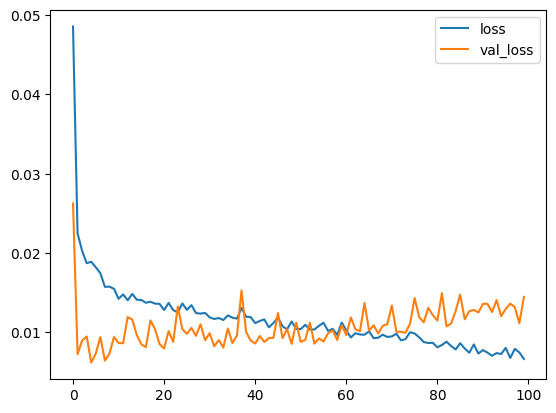

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history1.history)
losses.plot()

In [ ]:
print(testPredict.shape)
print(testY.shape)

(57, 1)
(1, 57)


In [ ]:
trainPredict = model1.predict(X_train)
testPredict = model1.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(-1, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(-1, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(57, 1)
(57, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 15924519.78 RMSE
Test Score: 28968497.41 RMSE


In [ ]:
plot_x = df_daily['Date'].copy()

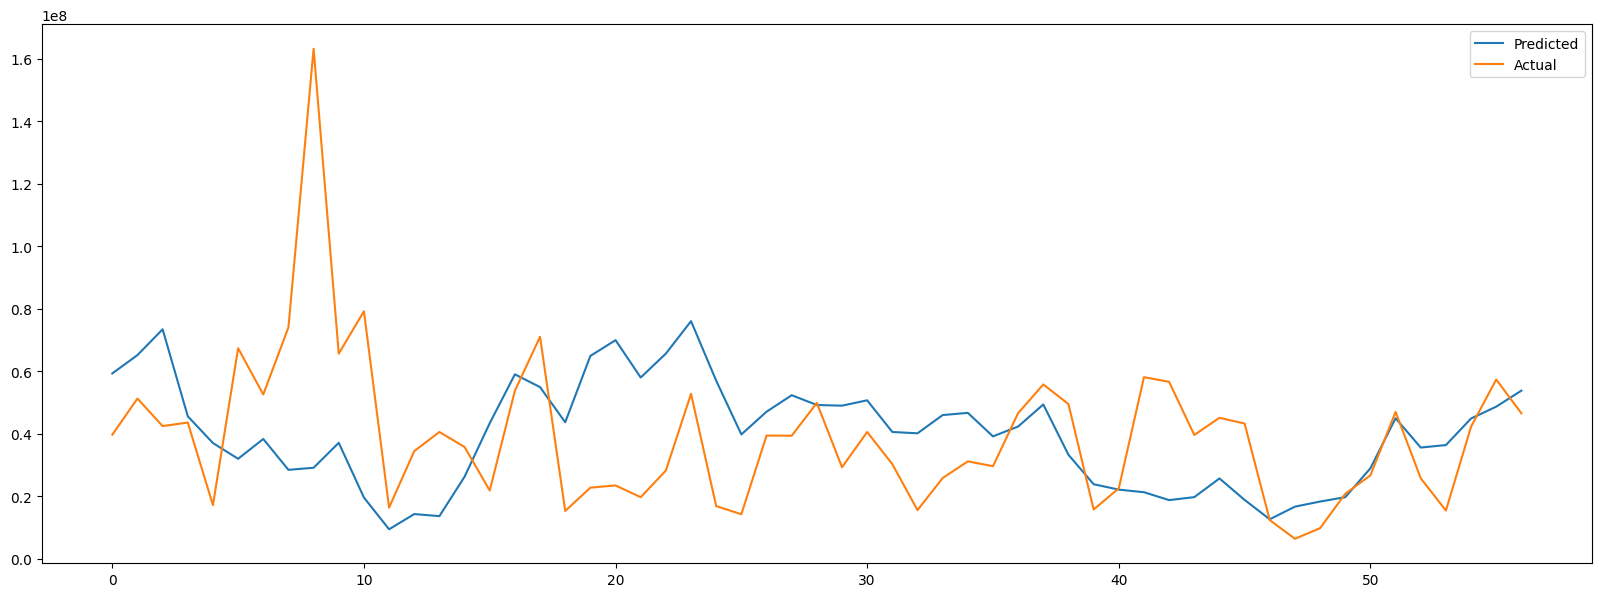

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-57:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

## Model 2 - Stack LSTM using Dropout

In [ ]:
#LSTM architecture
model2 = Sequential()
# First LSTM layer with Dropout regularisation
model2.add(LSTM(units=50, input_shape=(window,29),return_sequences=True))
model2.add(Dropout(0.2))
# Second LSTM layer
model2.add(LSTM(units=50))
model2.add(Dropout(0.2))

# The output layer
model2.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model2.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model2.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history2=model2.fit(X_train,y_train,epochs=100,batch_size=35, validation_data=(X_val, y_val), verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0677 - val_loss: 0.0336
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0267 - val_loss: 0.0074
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0227 - val_loss: 0.0098
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0208 - val_loss: 0.0122
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0207 - val_loss: 0.0089
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0224 - val_loss: 0.0083
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0235 - val_loss: 0.0070
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0176 - val_loss: 0.0078
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0222 - val_loss: 0.0072
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0191 - val_loss: 0.0072
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0191 - val_loss: 0.0080
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0

<Axes: >

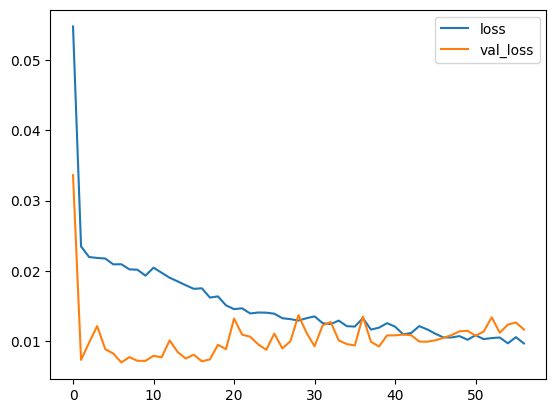

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history2.history)
losses.plot()

In [ ]:
trainPredict = model2.predict(X_train)
testPredict = model2.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(-1, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(-1, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
(57, 1)
(57, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 19021815.11 RMSE
Test Score: 29245604.38 RMSE


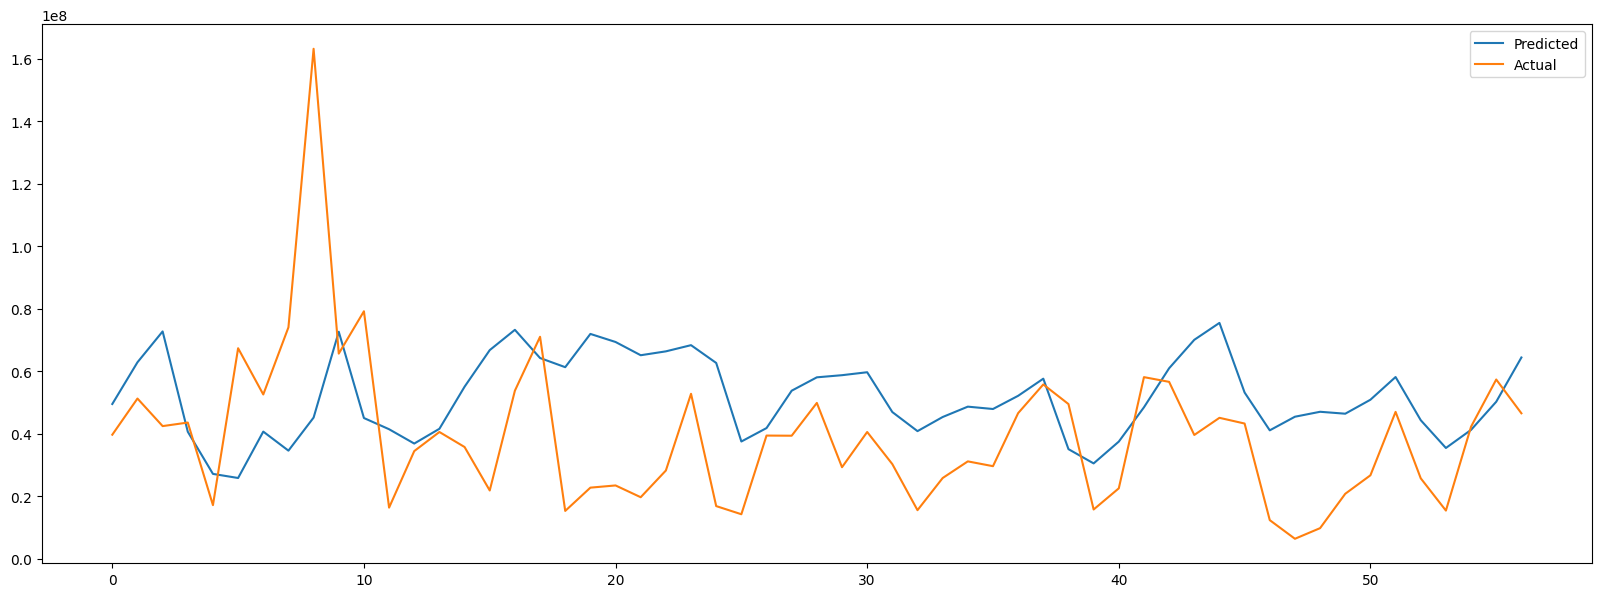

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-57:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

## Model 3 - Bidirectional LSTM

In [ ]:
# Stack LSTM architecture
model3 = Sequential()
# Bidirectional LSTM layer with Dropout regularisation
model3.add(Bidirectional(LSTM(units=50), input_shape=(window,29)))
model3.add(Dropout(0.2))
# The output layer
model3.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model3.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model3.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history3=model3.fit(X_train,y_train,epochs=100,batch_size=35, validation_data=(X_val, y_val), verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0613 - val_loss: 0.0369
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0257 - val_loss: 0.0097
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0217 - val_loss: 0.0104
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0183 - val_loss: 0.0091
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0161 - val_loss: 0.0092
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0160 - val_loss: 0.0127
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0175 - val_loss: 0.0074
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0165 - val_loss: 0.0082
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0159 - val_loss: 0.0101
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0155 - val_loss: 0.0147
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0184 - val_loss: 0.0097
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

<Axes: >

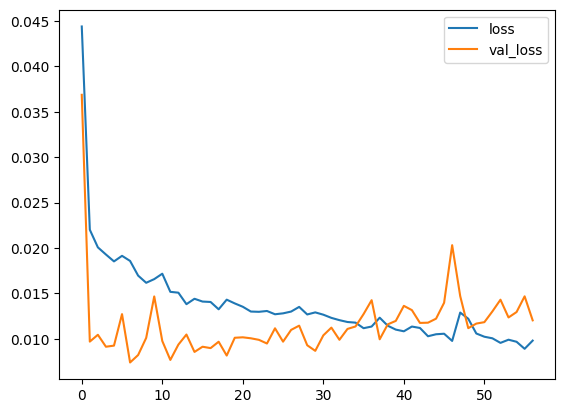

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history3.history)
losses.plot()

In [ ]:
trainPredict = model3.predict(X_train)
testPredict = model3.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(-1, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(-1, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
(57, 1)
(57, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 18938584.12 RMSE
Test Score: 29268619.23 RMSE


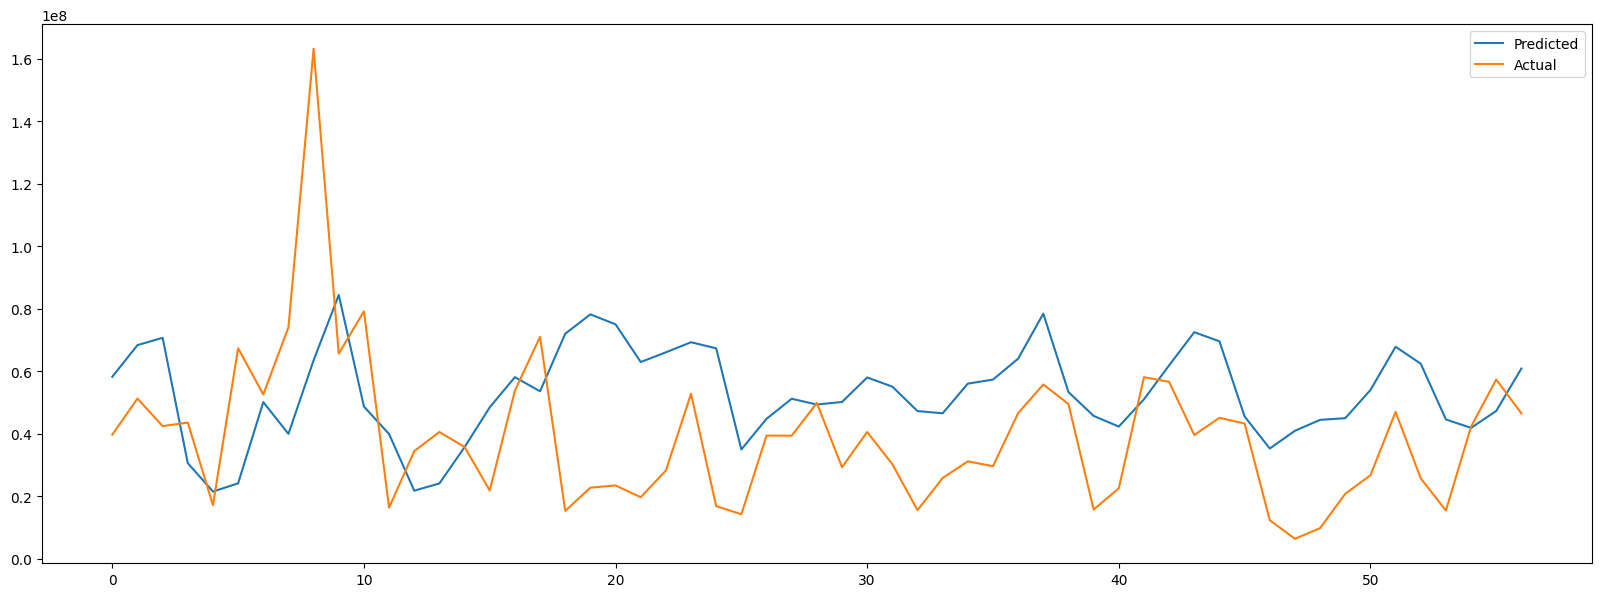

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-57:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

## Model 4 - GRU

In [ ]:
# Stack LSTM architecture
model4 = Sequential()
# GRU layer with Dropout regularisation
model4.add(GRU(units=50, input_shape=(window,29)))
model4.add(Dropout(0.2))

# The output layer
model4.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model4.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model4.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history4=model4.fit(X_train,y_train,epochs=100,batch_size=35, validation_data=(X_val, y_val), verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0616 - val_loss: 0.0228
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0258 - val_loss: 0.0077
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0178 - val_loss: 0.0135
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0187 - val_loss: 0.0102
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0150 - val_loss: 0.0104
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0154 - val_loss: 0.0093
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0164 - val_loss: 0.0128
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0160 - val_loss: 0.0084
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0131 - val_loss: 0.0114
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0133 - val_loss: 0.0087
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0142 - val_loss: 0.0132
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

<Axes: >

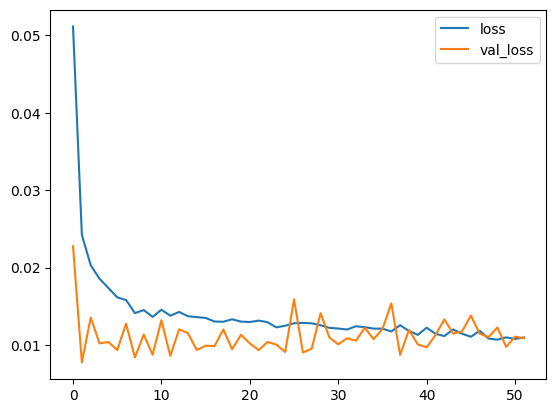

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history4.history)
losses.plot()

In [ ]:
trainPredict = model4.predict(X_train)
testPredict = model4.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(-1, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(-1, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(57, 1)
(57, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 20376759.28 RMSE
Test Score: 26001611.58 RMSE


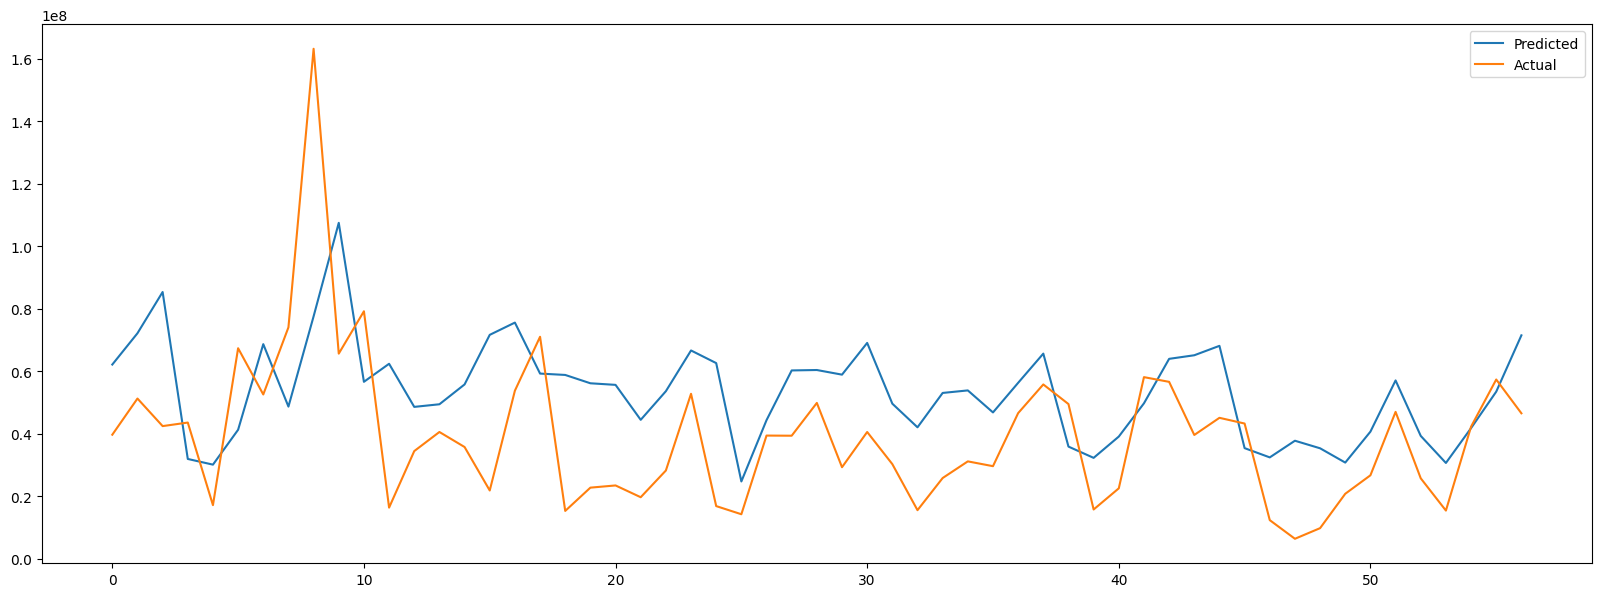

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-57:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

## Model 5 - LSTM using BatchNormalization and Regularization L1 & L2

In [ ]:
# LSTM using BatchNormalization and Regularization (L1 and L2)
#LSTM architecture
model5 = Sequential()
# First LSTM layer with Dropout regularisation
model5.add(LSTM(units=50, input_shape=(window,29),kernel_regularizer='l2'))
model5.add(BatchNormalization())
model5.add(Dropout(0.2))

# The output layer
model5.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model5.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))


# Compiling the RNN
model5.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history5=model5.fit(X_train,y_train,epochs=100,batch_size=35, validation_data=(X_val, y_val), verbose=1)
print ('compilation time : ', time.time() - start)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.5552 - val_loss: 0.4119
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4239 - val_loss: 0.3087
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3224 - val_loss: 0.2295
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2391 - val_loss: 0.1751
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1722 - val_loss: 0.1383
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1325 - val_loss: 0.1072
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1012 - val_loss: 0.0814
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0807 - val_loss: 0.0636
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0609 - val_loss: 0.0511
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0495 - val_loss: 0.0399
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0388 - val_loss: 0.0336
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

<Axes: >

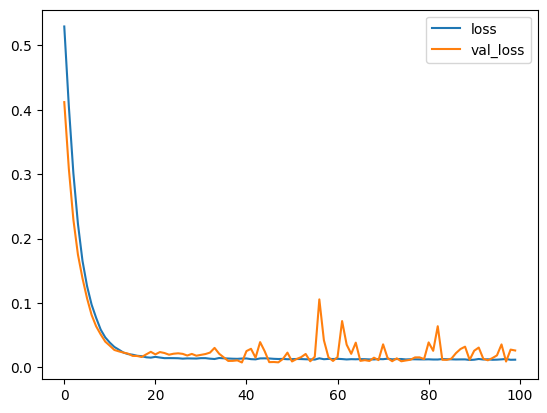

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history5.history)
losses.plot()

In [ ]:
trainPredict = model5.predict(X_train)
testPredict = model5.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(-1, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(-1, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(57, 1)
(57, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 26482562.75 RMSE
Test Score: 33557179.85 RMSE


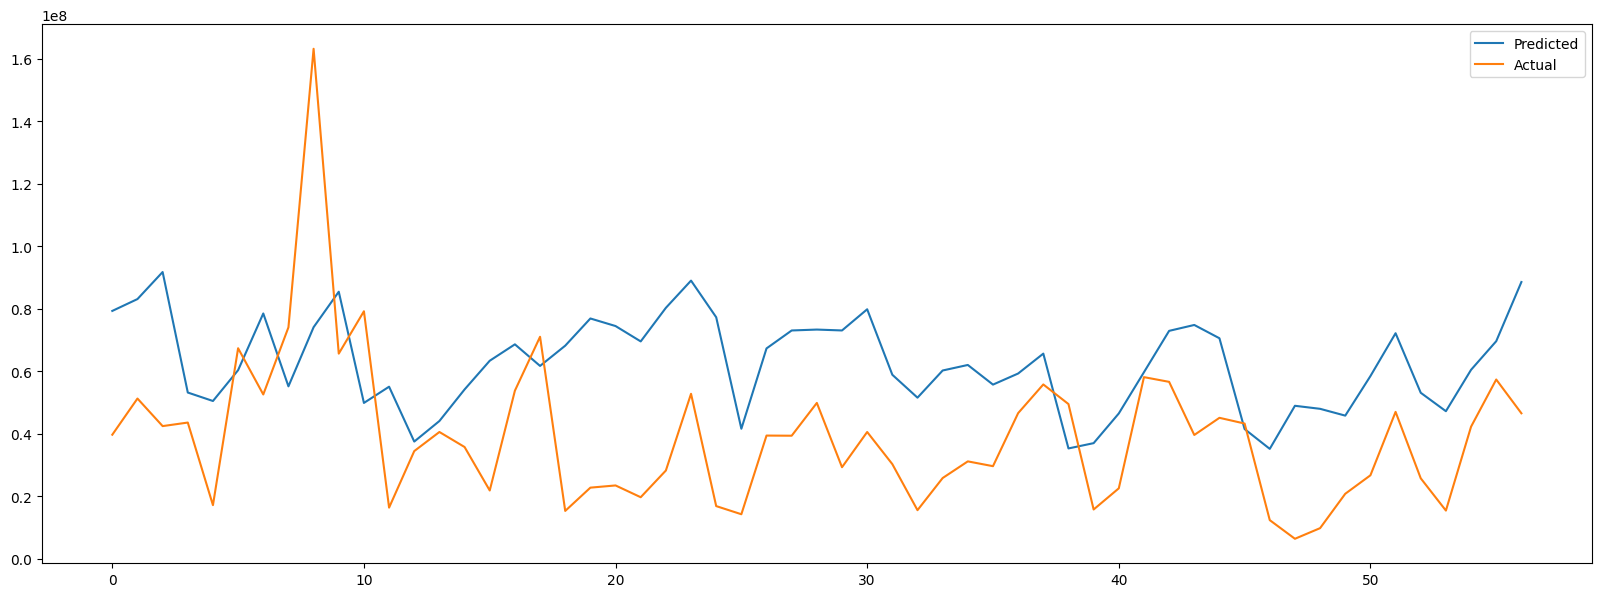

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-57:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

# Perbandingan Model

In [ ]:
model = [model1, model2, model3, model4, model5]
history = [history1, history2, history3, history4, history5] # Although history is not used in this cell, keeping it for completeness

print("Evaluation Metrics for LSTM Models:")
for i in range(len(model)):
    # Make predictions
    trainPredict = model[i].predict(X_train)
    testPredict = model[i].predict(X_test)

    # Inverse transform the predictions and actual values
    trainPredict = y_scaler.inverse_transform(trainPredict)
    trainY = y_scaler.inverse_transform([y_train])
    testPredict = y_scaler.inverse_transform(testPredict)
    testY = y_scaler.inverse_transform([y_test])

    # Calculate evaluation metrics
    mae = mean_absolute_error(testY[0], testPredict[:,0])
    mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])
    mase = mean_absolute_scaled_error(testY[0], testPredict[:,0])
    rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

    print(f"Model {i+1}")
    print(f"  Train Score: {mean_squared_error(trainY[0], trainPredict[:,0]) ** .5:.2f} RMSE")
    print(f"  Test Score: {rmse:.2f} RMSE")
    print(f"  MAE: {mae:.3f}")
    print(f"  MAPE: {mape:.3f}%")
    print(f"  MASE: {mase:.3f}")
    print("-" * 20)

Evaluation Metrics for LSTM Models:
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Model 1
  Train Score: 15788790.64 RMSE
  Test Score: 27723486.83 RMSE
  MAE: 20363303.980
  MAPE: 78.150%
  MASE: 1.102
--------------------
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Model 2
  Train Score: 19726012.49 RMSE
  Test Score: 25564230.70 RMSE
  MAE: 19511381.428
  MAPE: 71.803%
  MASE: 1.056
--------------------
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Model 3
  Train Score: 19916150.13 RMSE
  Test Score: 28165286.58 RMSE
  MAE: 21868041.389
  MAPE: 84.765%
  MASE: 1.183
--------------------
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Model 4
  Train Score: 20364268.59 RMSE
  Test Score: 23813837.28 RMSE
  MAE: 19268488.932
  MAPE: 74.058%
  MASE: 1.043
--------------------
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Model 5


In [ ]:
# Make trainscore and testscore to dataframe
name_of_model = ['LSTM', 'Stacked LSTM', 'Bidirectional LSTM', 'GRU', 'LSTM with BatchNormalization and Regularization']
df_score = pd.DataFrame({'Model':name_of_model,'Train Score': trainScore, 'Test Score': testScore})
df_score

,Model,Train Score,Test Score
0,LSTM,2.605443e+07,3.432472e+07
1,Stacked LSTM,2.605443e+07,3.432472e+07
2,Bidirectional LSTM,2.605443e+07,3.432472e+07
3,GRU,2.605443e+07,3.432472e+07
4,LSTM with BatchNormalization and Regularization,2.605443e+07,3.432472e+07


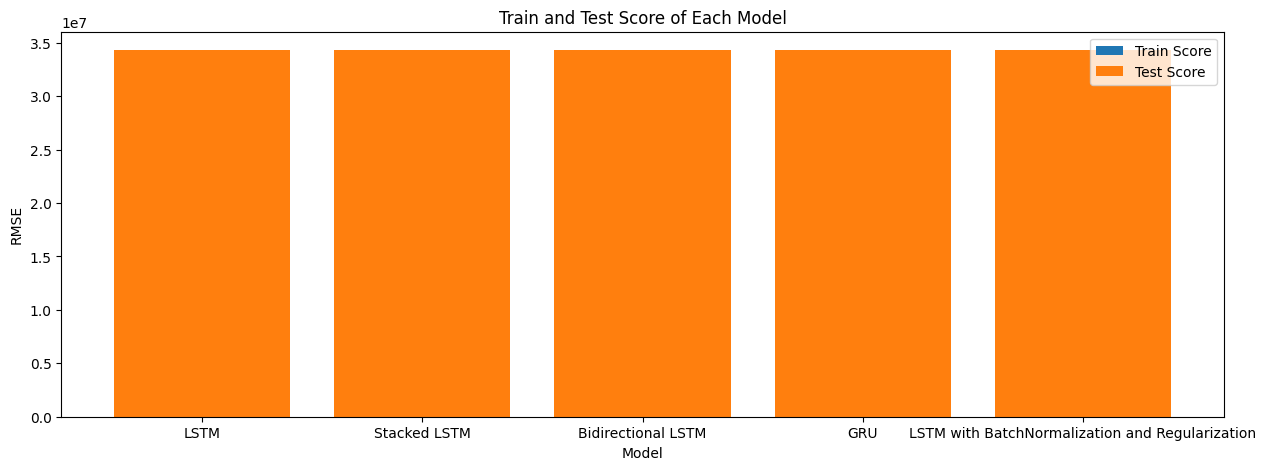

In [ ]:
# Plot the result with bar chart
plt.figure(figsize=(15, 5))
plt.bar(df_score['Model'], df_score['Train Score'], label='Train Score')
plt.bar(df_score['Model'], df_score['Test Score'], label='Test Score')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Train and Test Score of Each Model')
plt.legend(loc='best')
plt.show()

## Hyper Tune LSTM

In [ ]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
# Fungsi untuk membuat model dengan hyperparameter
def build_model(hp):
    modelTune = Sequential()
    # Layer LSTM pertama
    modelTune.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=16),
        return_sequences=False,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    modelTune.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Dense layer
    modelTune.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
                   activation='relu'))
    modelTune.add(Dense(1, activation='linear'))

    # Optimizer dengan learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=lr)

    modelTune.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
    return modelTune

# Callback untuk training
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='hyper_tuning',
    project_name='lstm_tuning'
)

# Jalankan tuning
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    batch_size=32
)

# Dapatkan hyperparameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Units LSTM: {best_hps.get('units')}
- Dropout: {best_hps.get('dropout')}
- Dense units: {best_hps.get('dense_units')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# Bangun model terbaik dan latih lagi
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Trial 90 Complete [00h 00m 12s]
val_loss: 0.006513193715363741

Best val_loss So Far: 0.005877771880477667
Total elapsed time: 00h 11m 59s

Best hyperparameters:
- Units LSTM: 64
- Dropout: 0.5
- Dense units: 64
- Learning rate: 0.001

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.0066 - val_mse: 0.0066 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0097 - val_mse: 0.0097 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0069 - val_mse: 0.0069 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0068 - val_mse: 0.0068 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0062 - val_mse: 0.0062 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - 

In [ ]:
# Bangun ulang model terbaik
best_model = Sequential()
best_model.add(LSTM(64, input_shape=(window, X_train.shape[2]), return_sequences=False))
best_model.add(Dropout(0.5))
best_model.add(Dense(64, activation='tanh'))
best_model.add(Dense(1, activation='linear'))

# Compile dengan learning rate terbaik
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
best_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Latih model dengan data train+val
X_train_full = np.concatenate([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

history = best_model.fit(
    X_train_full, y_train_full,
    epochs=100,
    batch_size=35,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.0554 - val_loss: 0.0119
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0247 - val_loss: 0.0118
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0193 - val_loss: 0.0115
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0192 - val_loss: 0.0125
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0139 - val_loss: 0.0113
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0159 - val_loss: 0.0119
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0162 - val_loss: 0.0117
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0162 - val_loss: 0.0127
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0175 - val_loss: 0.0117
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0181 - val_loss: 0.0115
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0158 - val_loss: 0.0118
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/ste

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Evaluation on Test Data
RMSE : 27974403.63
MAE  : 20273598.81
MAPE : 73.14%
R²   : -0.350


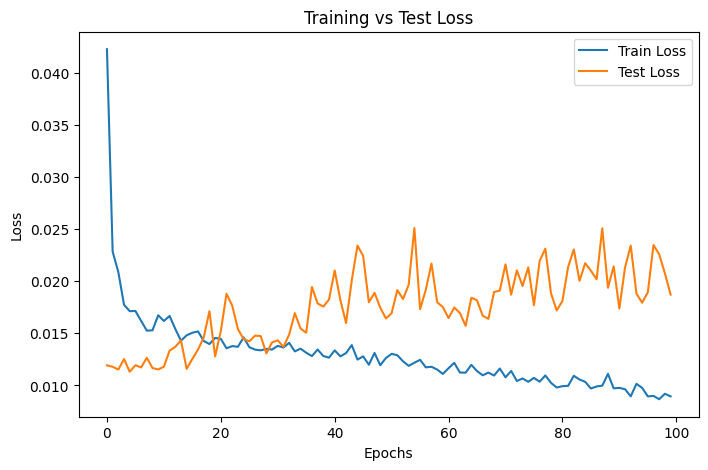

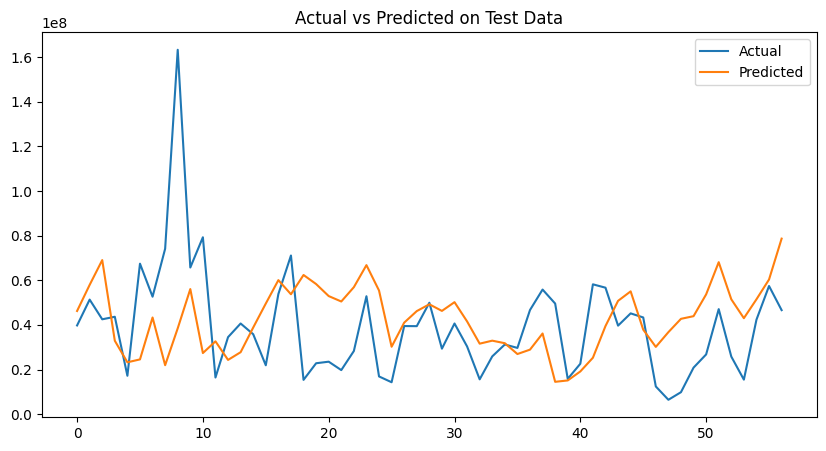

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Prediksi
y_test_pred = best_model.predict(X_test)

# Inverse transform ke skala asli
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_inv = y_scaler.inverse_transform(y_test_pred)

# Metrik evaluasi
rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_test_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_test_pred_inv)

print("Evaluation on Test Data")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")

# Loss curve
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.show()

# Prediksi vs aktual
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_test_pred_inv, label='Predicted')
plt.title('Actual vs Predicted on Test Data')
plt.legend()
plt.show()


# Prophet Model

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpffb_ovf5/jjtk5af6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpffb_ovf5/38lphk70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88824', 'data', 'file=/tmp/tmpffb_ovf5/jjtk5af6.json', 'init=/tmp/tmpffb_ovf5/38lphk70.json', 'output', 'file=/tmp/tmpffb_ovf5/prophet_modelpq73943s/prophet_model-20250909084009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
706,2025-12-07,-1.306384e+05,-3.056568e+07,3.430439e+07
707,2025-12-08,1.611866e+07,-1.779645e+07,4.872138e+07
708,2025-12-09,2.124016e+07,-1.057513e+07,5.409462e+07
709,2025-12-10,2.182540e+07,-1.048794e+07,5.067690e+07
710,2025-12-11,2.502987e+07,-6.921069e+06,5.513769e+07


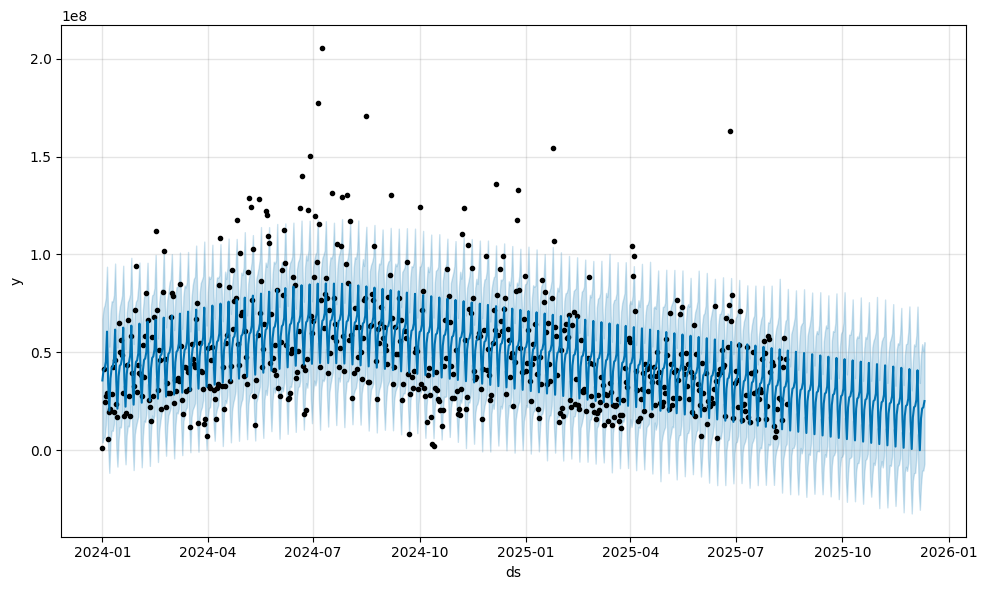

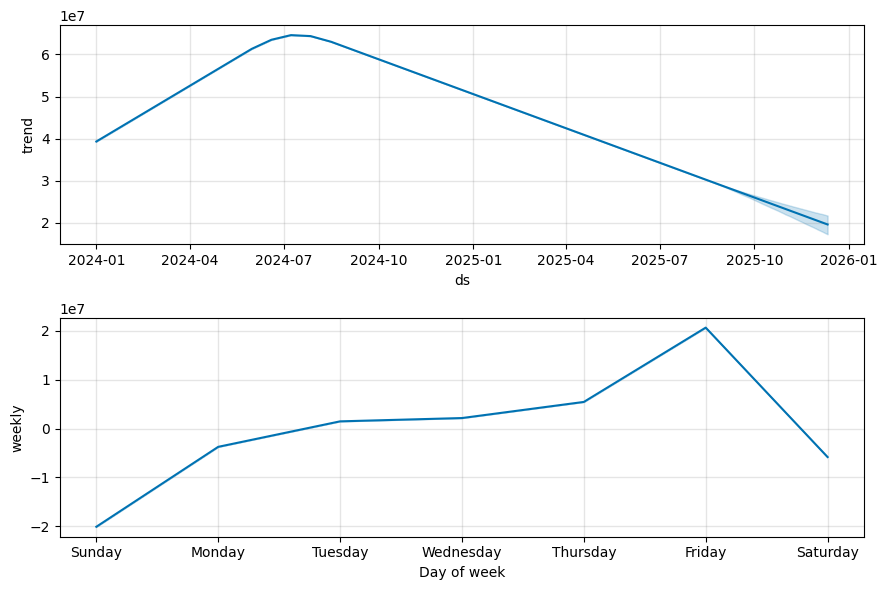

In [ ]:
from prophet import Prophet

# Siapkan data untuk Prophet
# Prophet membutuhkan kolom 'ds' (datestamp) dan 'y' (nilai yang akan diforecast)
df_prophet = df_daily[['Date', 'Revenue']].copy()
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Revenue': 'y'})

# Inisialisasi dan latih model Prophet
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Buat dataframe untuk future dates
future = model_prophet.make_future_dataframe(periods=len(test_df))

# Lakukan prediksi
forecast_prophet = model_prophet.predict(future)

# Tampilkan hasil prediksi
display(forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot hasil forecast
fig1 = model_prophet.plot(forecast_prophet)
fig2 = model_prophet.plot_components(forecast_prophet)

In [ ]:
# Evaluate Prophet model
# Extract the predicted values for the test set period
prophet_forecast_test = forecast_prophet['yhat'].iloc[len(train_df):len(train_df)+len(test_df)]

# Ensure the indices match for evaluation
prophet_forecast_test.index = test_df.index

# Calculate evaluation metrics
mae_prophet = mean_absolute_error(test_df['Revenue'], prophet_forecast_test)
mape_prophet = mean_absolute_percentage_error(test_df['Revenue'], prophet_forecast_test)
mase_prophet = mean_absolute_scaled_error(test_df['Revenue'], prophet_forecast_test)
rmse_prophet = np.sqrt(mean_squared_error(test_df['Revenue'], prophet_forecast_test))


print(f"Prophet Model Evaluation:")
print(f"MAE: {mae_prophet:.3f}")
print(f"MAPE: {mape_prophet:.3f}%")
print(f"MASE: {mase_prophet:.3f}")
print(f"RMSE: {rmse_prophet:.3f}")

Prophet Model Evaluation:
MAE: 13688516.966
MAPE: 43.140%
MASE: 0.761
RMSE: 20012921.266


# API Development

In [ ]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
added 22 packages in 2s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

In [ ]:
%%writefile chat.html
<!DOCTYPE html>
<html>
<head><title>Chat</title></head>
<body>
  <h2>Forecast Chatbot</h2>
  <form id="chat-form">
    <input id="msg" type="text" placeholder="Ketik pesan...">
    <button type="submit">Kirim</button>
  </form>
  <div id="chat"></div>
  <script>
    const form = document.getElementById("chat-form");
    form.onsubmit = async (e) => {
      e.preventDefault();
      let msg = document.getElementById("msg").value;
      let res = await fetch("/chat", {
        method: "POST",
        headers: {"Content-Type":"application/json"},
        body: JSON.stringify({message: msg})
      });
      let data = await res.json();
      document.getElementById("chat").innerHTML += `<p><b>You:</b> ${msg}</p><p><b>Bot:</b> ${data.reply}</p>`;
    };
  </script>
</body>
</html>

Writing chat.html


In [ ]:
import os
import pandas as pd
import re
import threading
import subprocess
from flask import Flask, request, jsonify
from statsmodels.tsa.arima.model import ARIMAResults

app = Flask(__name__)

# === Forecast Function ===
def run_forecast(n_forecast,
                 model_folder="/content/",
                 train_csv="/content/train_df.csv",
                 test_csv="/content/test_df.csv"):

    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)

    all_forecasts = pd.DataFrame()

    for filename in os.listdir(model_folder):
        if filename.endswith(".pkl"):
            model_path = os.path.join(model_folder, filename)
            loaded_model = ARIMAResults.load(model_path)

            forecast = loaded_model.forecast(
                steps=n_forecast,
                exog=test_df[['Room Nights', 'Meal Plan', 'Room Category', 'Length of Stay', 'ADR',
                              'Month', 'Seasonality', 'Day of Week','Weekend Flag','Channel Name_Booking.com',
                              'Channel Name_Ctrip', 'Channel Name_DOTW', 'Channel Name_Expedia',
                              'Channel Name_HRS', 'Channel Name_MG Jarvis', 'Channel Name_Mikitravel',
                              'Channel Name_Sunhotels', 'Channel Name_Traveloka', 'Channel Name_Trip.com V2',
                              'Channel Name_hotusa', 'Channel Name_hyperguest', 'Channel Name_kliknbook',
                              'Channel Name_metglobal', 'Channel Name_opengds', 'Channel Name_synxisxml',
                              'Channel Name_tbo', 'Channel Name_tiket', 'Channel Name_travelokav2']].iloc[:n_forecast]
            )

            all_forecasts[filename.replace(".pkl", "")] = forecast.reset_index(drop=True)

    all_forecasts["Total_Revenue"] = all_forecasts.sum(axis=1)
    all_forecasts.index = test_df.index[:n_forecast]
    return all_forecasts


# === API Endpoint ===
@app.route('/forecast')
def forecast_api():
    n_forecast = int(request.args.get("n_forecast", 118))
    df_forecast = run_forecast(n_forecast)
    result = df_forecast.reset_index().to_dict(orient="records")
    return jsonify({"forecast": result})


@app.route('/chat', methods=['POST'])
def chat_api():
    data = request.get_json()
    user_msg = data.get("message", "").lower()

    if "forecast" in user_msg:
        match = re.search(r'\d+', user_msg)
        n_forecast = int(match.group()) if match else 118
        df_forecast = run_forecast(n_forecast)
        total_rev = df_forecast["Total_Revenue"].sum()
        reply = f"✅ Forecast {n_forecast} hari ke depan selesai.\nTotal revenue prediksi: {total_rev:,.0f}"
    else:
        reply = "🙏 Saya hanya bisa bantu forecast. Contoh: 'tolong forecast 30 hari ke depan'."

    return jsonify({"reply": reply})


@app.route('/')
def home():
    return "<h2>Flask Forecast API running 🎉</h2><p>Gunakan endpoint <b>/chat</b> atau <b>/forecast</b></p>"


# === Run Flask + LocalTunnel ===
def run_flask():
    app.run(port=5000)

# Jalankan Flask di thread terpisah
thread = threading.Thread(target=run_flask)
thread.start()

# Buka tunnel ke publik
!lt --port 5000

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


your url is: https://quiet-banks-film.loca.lt
 CTRL+C
CTRL+C
^C
